# TRANSACTION FRAUD DETECTION 

## Context

PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

## Problems

There is a lack of public available datasets on financial services and specially in the emerging mobile money transactions domain. Financial datasets are important to many researchers and in particular to us performing research in the domain of fraud detection.

## Goals

To analyse the fraud transaction and to classify/predict the fraud detection as accurately as possible.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [111]:
!pip install shap


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 17.1 MB/s eta 0:00:00


In [1]:
!pip install jupyterthemes 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.8 MB/s eta 0:00:00


In [2]:
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [4]:
# Importing packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#from jupyterthemes import jtplot
#jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
from sklearn import set_config
set_config(print_changed_only=False)
from xgboost import plot_importance, to_graphviz
from sklearn.model_selection import train_test_split
%matplotlib inline
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import average_precision_score

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

warnings.filterwarnings("ignore", category=UserWarning)

warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
data = pd.read_csv('/content/drive/MyDrive/creditFraud.csv')

In [6]:
data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [7]:
# Inspecting the data
data.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [8]:
# Information of data - The data set has 6.3 million rows and 11 columns

pd.DataFrame(data.columns, columns=['Features'])

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## Features Descriptions

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction, C = Client, M = Merchant

oldbalanceDest - initial balance of recipient before the transaction.

newbalanceDest - new balance of recipient after the transaction.

isFraud - This is the transactions made by the fraudulent agents inside the simulation.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [9]:
data.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [10]:
#checking is there any null values in dataset

data.isnull().sum()


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [11]:
# Checking each features description

dfDesc = []

for i in data.columns:
    dfDesc.append([
        i,
        data[i].dtypes,
        data[i].isna().sum(),
        ((data[i].isna().sum())/len(data) *100).round(2),
        data[i].nunique(),
        data[i].drop_duplicates().head(4).values
    ])
print(data.shape[0])
pd.DataFrame(data = dfDesc, columns = ['Features', 'D types', 'Null', 'Null%', 'Unique', 'Unique Value'])


     

6362620


,Features,D types,Null,Null%,Unique,Unique Value
0,step,int64,0,0.0,743,"[1, 2, 3, 4]"
1,type,object,0,0.0,5,"[PAYMENT, TRANSFER, CASH_OUT, DEBIT]"
2,amount,float64,0,0.0,5316900,"[9839.64, 1864.28, 181.0, 11668.14]"
3,nameOrig,object,0,0.0,6353307,"[C1231006815, C1666544295, C1305486145, C84008..."
4,oldbalanceOrg,float64,0,0.0,1845844,"[170136.0, 21249.0, 181.0, 41554.0]"
5,newbalanceOrig,float64,0,0.0,2682586,"[160296.36, 19384.72, 0.0, 29885.86]"
6,nameDest,object,0,0.0,2722362,"[M1979787155, M2044282225, C553264065, C38997010]"
7,oldbalanceDest,float64,0,0.0,3614697,"[0.0, 21182.0, 41898.0, 10845.0]"
8,newbalanceDest,float64,0,0.0,3555499,"[0.0, 40348.79, 157982.12, 51513.44]"
9,isFraud,int64,0,0.0,2,"[0, 1]"


No missing values are detected on the dataset.

nameDest is only half of the nameOrig, explained by the dataset, that M stands for merchant which play a passive role during the simulation and the only functions they have is to serve the clients during cash in and cash out transactions.


In [12]:
# looking at statistical description of the data

data.describe().T


,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


##### From the first look, we could see on oldbalanceOrig feature has min value of 0. If the transaction type is Cash-In or Top up in familiar way to address mobile payment app, then oldbalanceOrg being zero 0 is acceptable, but if the newbalanceOrg stays 0 then it could be interpreted as missing values. 

##### Other types of transaction type with 0 oldbalanceOrg could be intrepreted as missing values.

## 1. Handling Missing Values

In [13]:
# Below is to check if there are zero balance on the original old and new balance.

data[(data['type']=='CASH_IN') & (data['oldbalanceOrg']==0) & (data['newbalanceOrig']==0) & (data['amount']!=0)]



,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud


##### Turns out in transaction type of Cash-In there were no errors/missing values since, after cash-in or top up there were no zero newbalanceOrig


##### Now, below we are checking if the newbalanceDest amount - amount of transaction equals to the amount of oldbalanceDest it means the money is add up correctly.
##### And if the money add up correctly but the oldbalanceOrg is zero means it is a missing value


In [14]:
# Copying values of amount feature

mask1 = data.loc[(data['oldbalanceOrg']==0)&((data['newbalanceDest'] - data['amount']) == data['oldbalanceDest'])&(data['amount']!=0),'amount'].values

In [15]:
# Paste the values of amount into oldbalanceOrg

data.loc[((data['oldbalanceOrg']==0)&((data['newbalanceDest'] - data['amount']) == data['oldbalanceDest'])&(data['amount']!=0)),'oldbalanceOrg'] = mask1


In [16]:
# check to see if its filled
data.iloc[[852]]

# the old balance succesfully change from zero into the amount of transaction



,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
852,1,CASH_OUT,6039.61,C1893563925,6039.61,0.0,C1653844940,31164.0,37203.61,0,0


In [17]:
# Since the data is imbalance, I will Drop zero values oldbalanceOrg which isFraud = 0.

data.drop(data.loc[(data['oldbalanceOrg']==0) & (data['newbalanceOrig']==0) & (data['amount']!=0) & (data['isFraud']==0)].index, inplace=True)


In [18]:
# Checking if its dropped or not

data.loc[(data['oldbalanceOrg']==0) & (data['newbalanceOrig']==0) & (data['amount']!=0) & (data['isFraud']==0)]


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud


In [19]:
# resetting the index
data.reset_index(inplace=True)

# Checking Data after imputing
data.shape

(4863726, 12)

In [20]:
data.head()

,index,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Initial Take on the Dataset

The fraudster is trying to take control of the victim accounts and trying to empty the victim balance with 2 methods:
1. By Transfer it to several accounts as mule to temporarily receive the money before its cash out of the system
2. Directly using merchant to cash out the maximum balance allowed.

Going by those statements, I will focusing on payment type of Transfer and cash out

By looking on the newbalanceOrg = 0 and the amount is equal to oldbalanceOrg, it is an attempt to emptying balance.

I will start the analysis only where the amount isFlaggedFraud by the system which is 200,000 above.

## Exploratory Data Analysis

isFraud Distribution amount: 
0    4855513
1       8213
Name: isFraud, dtype: int64


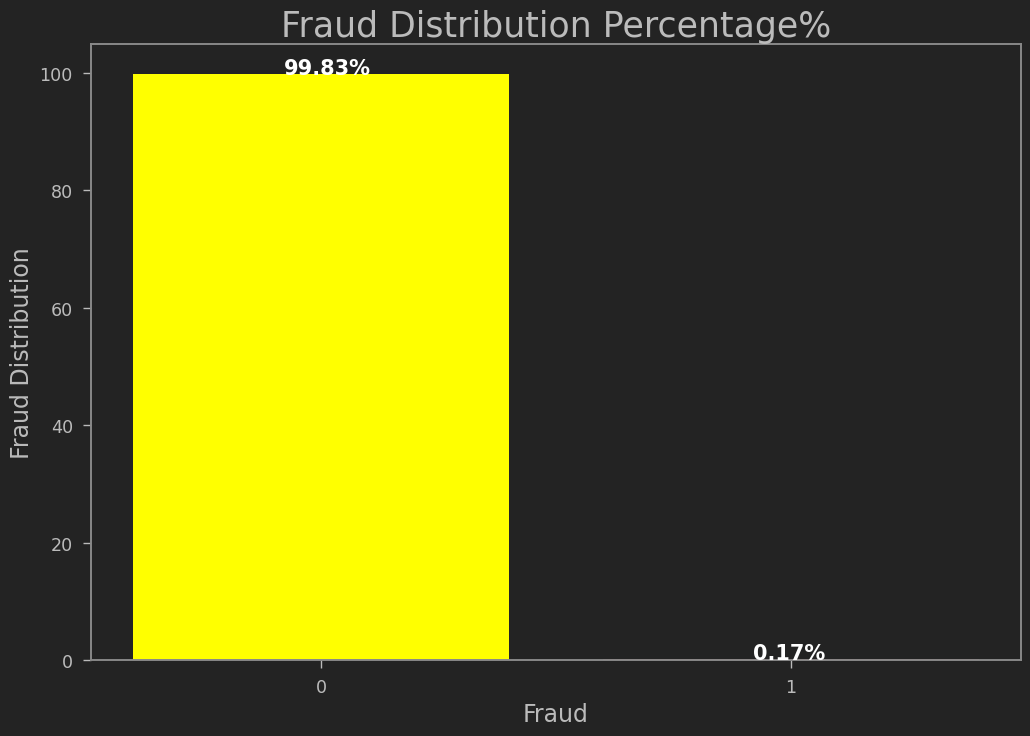

In [21]:
# Checking the distribution of target columns
print(f"isFraud Distribution amount: \n{data['isFraud'].value_counts()}")

Fraud = round(data['isFraud'].value_counts(normalize= True) * 100,2)
x = Fraud.index
y = Fraud.values

plt.figure(figsize=(12,8))  
plt.bar(x, y,color=['yellow','salmon']);
plt.xlabel('Fraud',fontdict={'fontsize': 17})
plt.ylabel('Fraud Distribution',fontdict={'fontsize': 17}) 
plt.title('Fraud Distribution Percentage%', fontdict={'fontsize': 25})
for i, v in enumerate(y):   
    plt.text(i-0.08,v+0,f'{v}%',fontweight='bold',color='white',fontsize=15)
plt.xticks([0,1])
plt.show()

# This dataset fraud detection is imbalance, only 0.17% from 4.8 million transactions where tagged/classified as Fraud.
# Next, I will take a further look into isFlaggedFraud feature.


In [22]:
print(f"The Number of transaction with minimum amount of 200,000: {data[data['amount']>200000].amount.count():,}")
print(f"The total data isFlaggedFraud: {data[data['isFlaggedFraud']==1].type.count()}")
print(f"The percentage of data isFlaggedFraud: {(data[data['isFlaggedFraud']==1].type.count()/data[data['amount']>200000].amount.count())*100}")


The Number of transaction with minimum amount of 200,000: 1,355,511
The total data isFlaggedFraud: 16
The percentage of data isFlaggedFraud: 0.0011803666661502562


#### From the feature description, we know that isFlaggedFraud is when the system marked an illegal attempt to transfer more than 200.000 in a single transaction. But, we do not know how the system works.
#### But we can clearly see that the amount of transaction with more than 200,000 are 1.3 millions data and only 16 transactions/0.001% of them isFlaggedFraud.
#### Since it shows an unreliability information, we can drop this feature in our further analysis


<Axes: xlabel='isFraud', ylabel='step'>

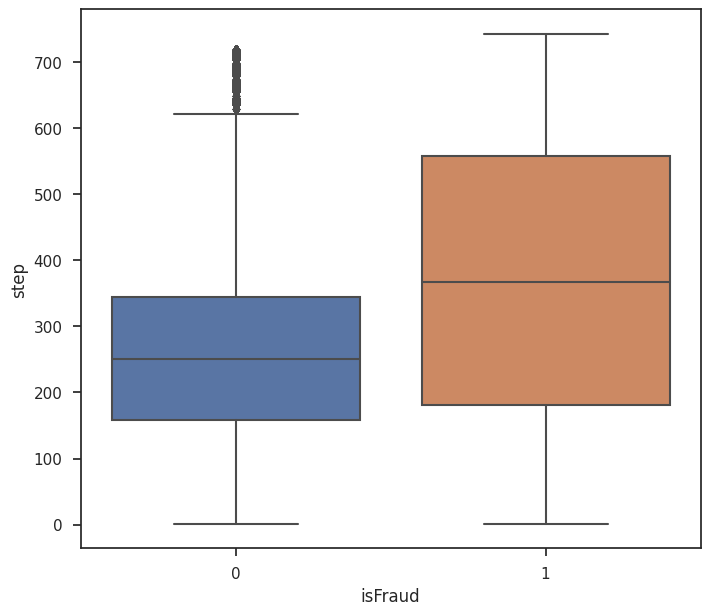

In [107]:
#Box Plot visualization
sns.boxplot(x=data.isFraud,y=data.step)


Transaction types deemed as Fraud: ['TRANSFER', 'CASH_OUT']


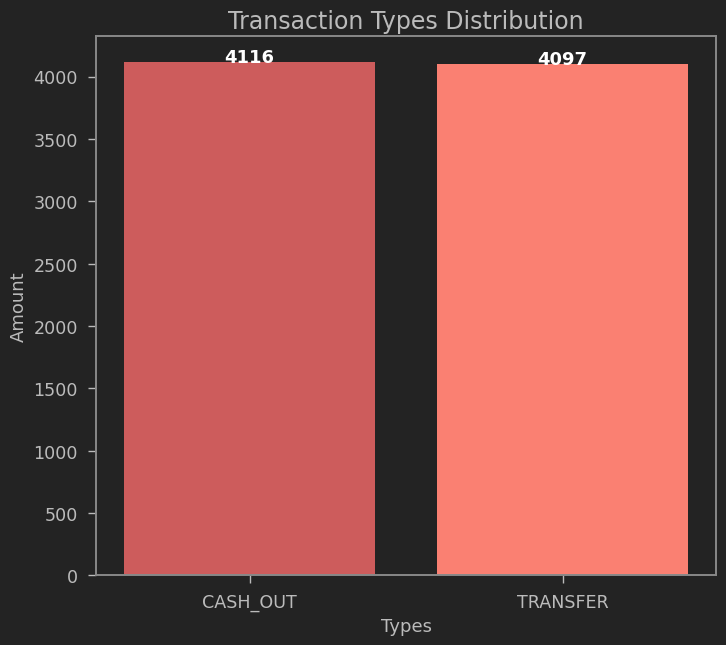

In [23]:
# Checking which Transaction type were detected as fraud

Types = round(data.loc[(data['isFraud']==1),'type'].value_counts(),2)
print(f"Transaction types deemed as Fraud: {[i for i in  data[data['isFraud']==1]['type'].unique()]}")

plt.bar(x=Types.index, height=Types.values, color=['indianred','salmon'])
for i, v in enumerate(Types.values):   
    plt.text(i-0.08,v+3,f'{v}',fontweight='bold',color='white',fontsize=13)
plt.xlabel('Types',fontdict={'fontsize': 13})
plt.ylabel('Amount',fontdict={'fontsize': 13}) 
plt.title('Transaction Types Distribution', fontdict={'fontsize': 17})
plt.show()


Transaction deemed as fraud were only found in Transfer and Cashout types. 
The total count of Fraud detected on both Types are similar almost 50:50
As mentioned above on my initial takes, the fraudster modus operandi after taking over the victim account is to Transfer it then cash it out.
Now, we can drop/delete rows which contain other types of transaction since, because only in these two types of transaction fraud is detected.


 Scatter plot matrix on dataset

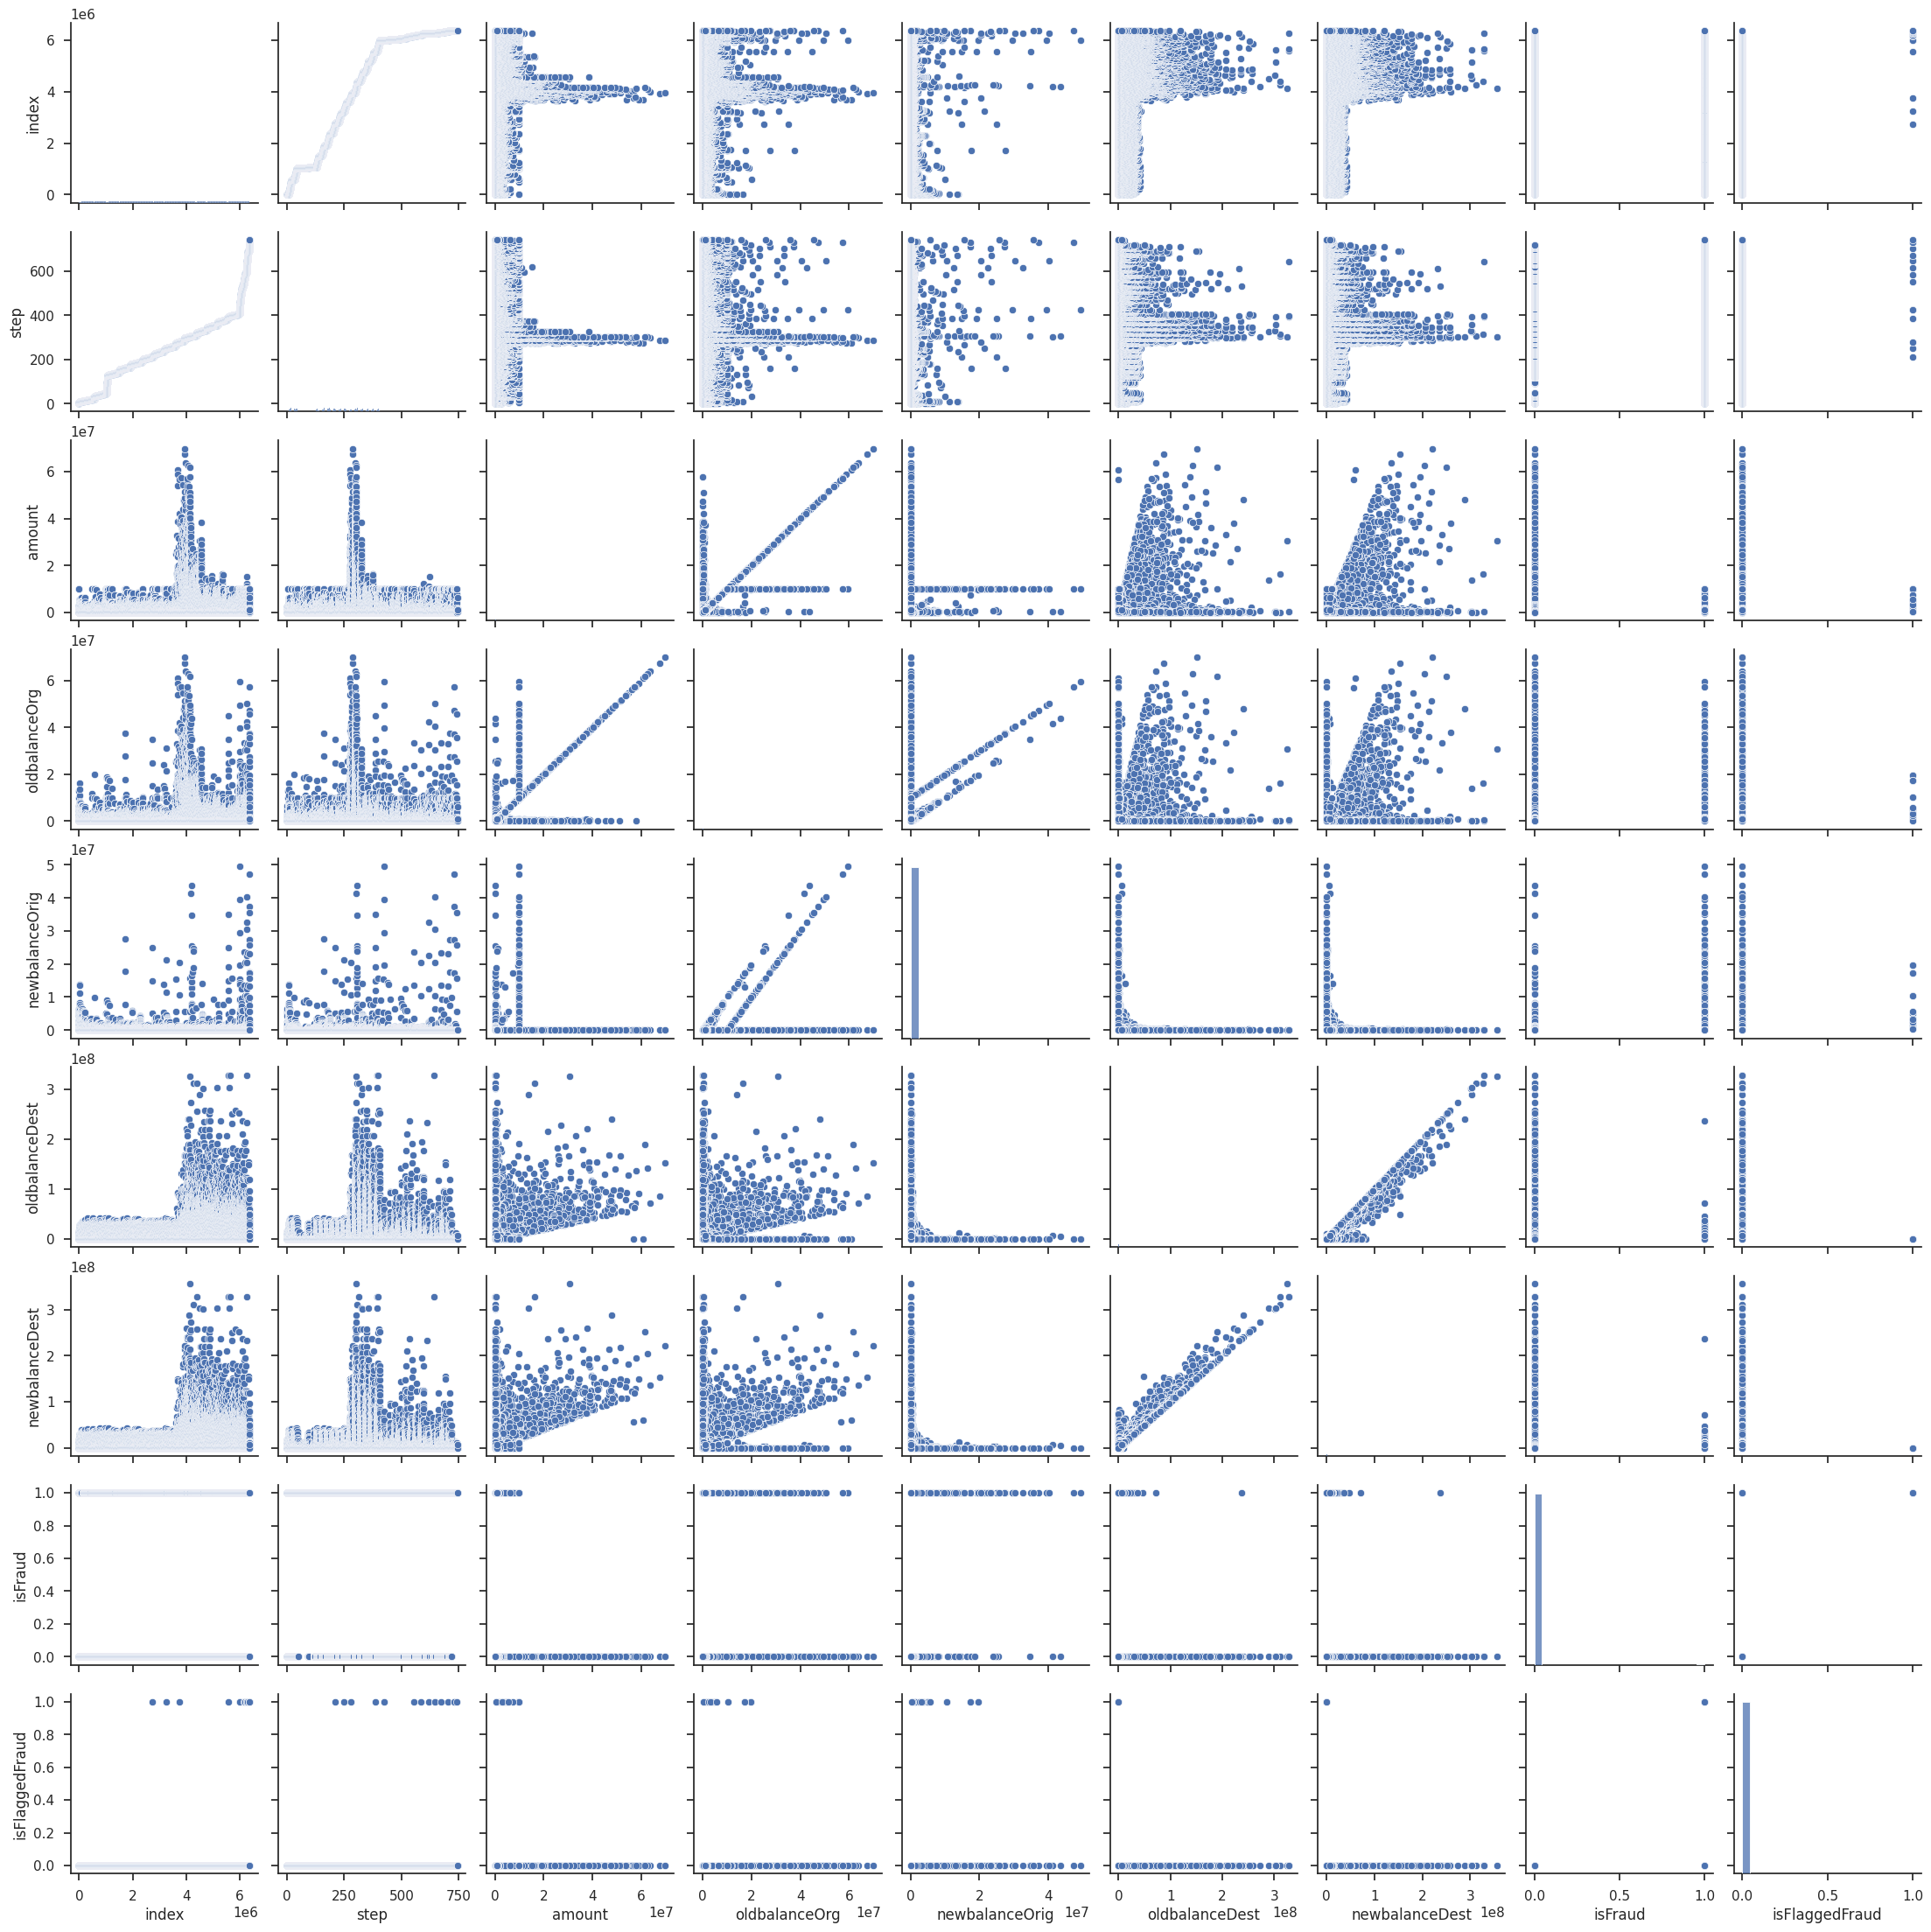

In [101]:
sns.set(style='ticks')
sns.pairplot(data)
plt.show()

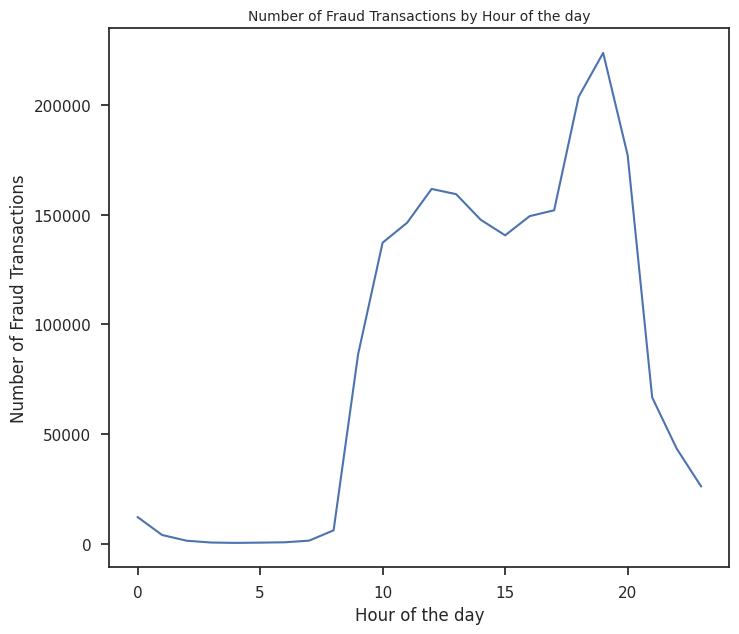

In [103]:
#plot showing the fraud wrt hour of the day
data['hourOfDay']=data['step']%24
hourly_fraud_count=data.groupby('hourOfDay').size()
plt.plot(hourly_fraud_count.index,hourly_fraud_count.values)
plt.title('Number of Fraud Transactions by Hour of the day',fontsize=10)
plt.xlabel('Hour of the day')
plt.ylabel('Number of Fraud Transactions')
plt.show()

Checking the amount of transaction took place in different time stamp

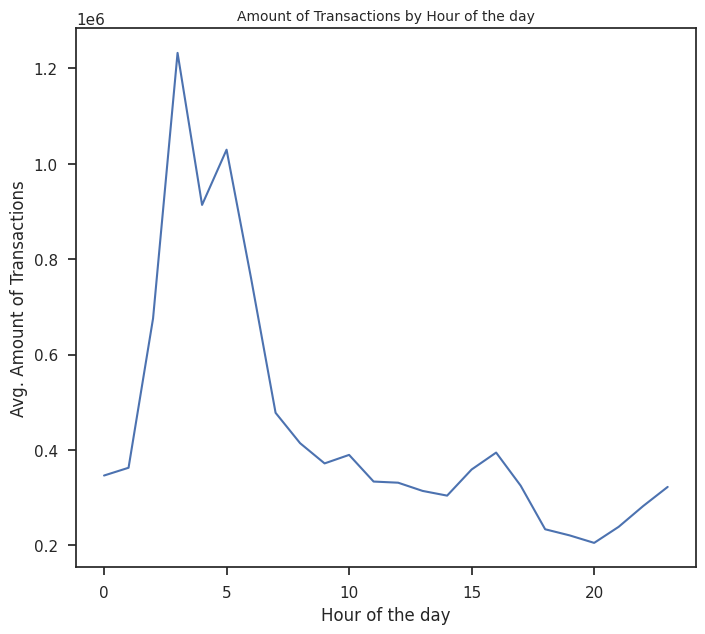

In [104]:
hourly_transaction=data.groupby('hourOfDay')['amount'].mean()
plt.plot(hourly_transaction.index,hourly_transaction.values)
plt.title('Amount of Transactions by Hour of the day',fontsize=10)
plt.xlabel('Hour of the day')
plt.ylabel('Avg. Amount of Transactions')
plt.show()

(0.0, 23.0)

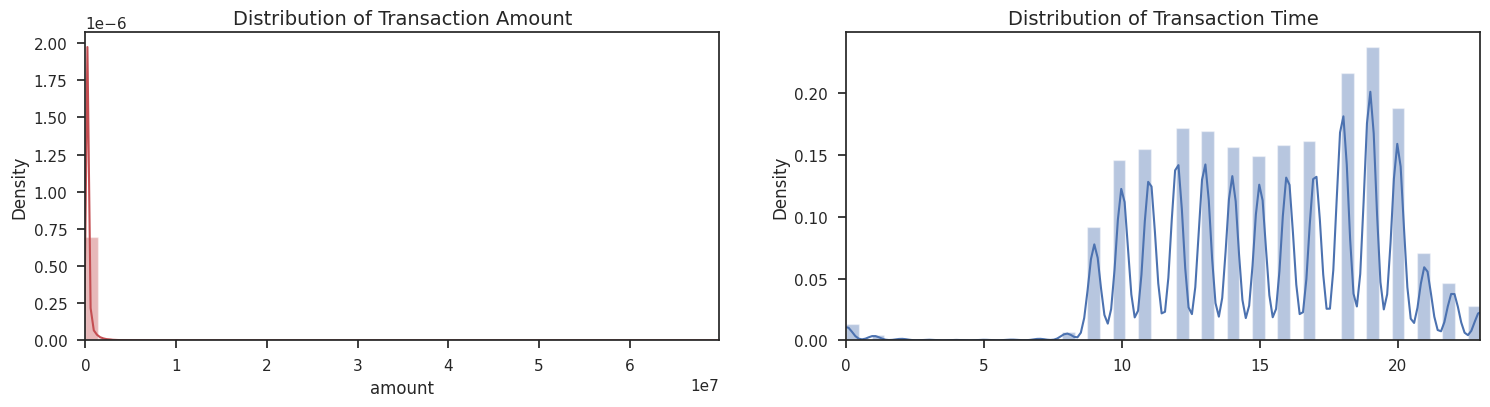

In [105]:
#lets check the distribution of transaction amount and transaction time
fig,ax=plt.subplots(1,2,figsize=(18,4))
amount_val=data['amount']
time_val=data['hourOfDay'].values

sns.distplot(amount_val,ax=ax[0],color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

### Since the fraudster could possibly make a transaction through merchant and cash out the money. 

#### Below, we are looking for transaction with name Destination is merchant and isFraud == 1, turns out there were no transaction deemed as fraud when it involved transaction to merchant

In [24]:
data[(data['isFraud']==1) & (data['nameDest'].str.contains('M'))]

# Theres no transaction deemed as fraud when the transaction destination are merchants

,index,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud


In [25]:
# Since the modus operandi of the fraudster transfer the balance into temporary account then cash it out, we want to see if the name destination tagged as Fraud -- 
# would be in the name origin that Cashout the money.

(data.loc[(data['isFraud'] == 1) & (data['type'] == 'TRANSFER'),'nameDest'].isin(data.loc[(data['isFraud'] == 1) & (data['type'] == 'CASH_OUT'),'nameOrig'])).value_counts()

#It turns out, whenever the NameDestination get a money and tagged as isFraud, it never shows up as the nameOrigin that cashout the money that were tagged as isFraud.


False    4097
Name: nameDest, dtype: int64

#### Now we want to see, if there any nameDestination tagged as isFraud and appeared as nameOrigin that Cashout the money and not tagged as Fraud


In [26]:

# df.loc[(df['isFraud'] == 1) & (df['type'] == 'TRANSFER'),'nameDest'].isin(df.loc[(df['isFraud'] == 0) & (df['type'] == 'CASH_OUT'),'nameOrig'])
test = pd.DataFrame(data[(data['isFraud']==1) & (data['type'] == 'TRANSFER')]['nameDest'].isin(data[(data['isFraud']==0) & (data['type'] == 'CASH_OUT')]['nameOrig']))
test[test['nameDest']==True]
a1 = data.loc[[767880,4863662],:]
a2 = data[(data['nameOrig']=='C1714931087') | (data['nameOrig']=='C1023330867') ]
pd.concat([a1,a2]).sort_values('step')

,index,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
767880,1030443,65,TRANSFER,1282971.57,C1175896731,1282971.57,0.00,C1714931087,0.00,0.00,1,0
873538,1168398,132,CASH_OUT,29084.28,C1023330867,51999.00,22914.72,C1422447255,0.00,29084.28,0,0
4692287,6149940,546,CASH_OUT,18091.05,C1714931087,197227.00,179135.95,C1339132632,66177.84,84268.89,0,0
4863662,6362556,738,TRANSFER,814689.88,C2029041842,814689.88,0.00,C1023330867,0.00,0.00,1,0


#### There are 2 nameOrigin that were tagged as non fraud when Cash out the money but were tagged isFraud when it was a nameDestination.
#### However, if we take a look at step (which is a unit of time) only account number C1714931087 that were fit the fraudster modus operandi, the transfer were tagged as isFraud but when Cashout - is not detected as fraud.

#### Since the evidence is not enough, only 1 account when transfer earlier detected as fraud


In [27]:
# Checking on the amount descriptive stats

Transfer_fraud = data.loc[(data['isFraud'] == 1) & (data['type'] == 'TRANSFER'),['amount']].describe().T
CashOut_fraud = data.loc[(data['isFraud'] == 1) & (data['type'] == 'CASH_OUT'),['amount']].describe().T
fraud_types = pd.concat([Transfer_fraud,CashOut_fraud])
fraud_types

# On both types of transaction, it has similar stats, that the median amount of transaction around 440,000 with q1 amount of 125,000


,count,mean,std,min,25%,50%,75%,max
amount,4097.0,1.480892e+06,2.414890e+06,63.8,128417.96,445705.760,1534985.07,10000000.0
amount,4116.0,1.455103e+06,2.393842e+06,0.0,125464.45,435516.905,1500761.03,10000000.0


In [28]:

# Dropping the other types of transaction since fraud only detected on Transfer and Cash Out

data.drop(data.loc[(data['type']!='CASH_OUT') & (data['type']!='TRANSFER')].index, inplace=True)


In [29]:
# resetting the index and check shape


print(data.shape)


(2048815, 12)


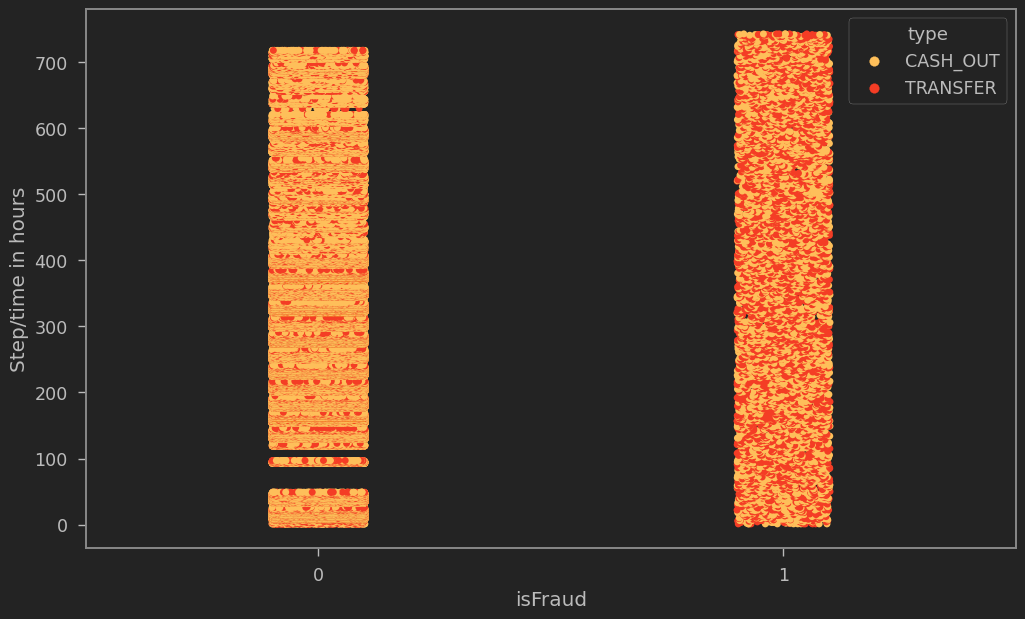

In [30]:
# Checking the step/time in hours

plt.figure(figsize=(12,7))
sns.stripplot(x=data['isFraud'], y=data['step'], hue=data['type'],palette='YlOrRd');
plt.ylabel('Step/time in hours')
plt.show()

From the plot below, we could see the transaction deemed as fraud were spread evenly from the 1st hour to end.
While non fraud transactions in below 100 hours seems have a break from any transaction
the number of Cashout type transaction were more than Transfer transaction on non fraud transaction, 
while on fraud transaction, the types of these two transactions were spread evenly.


<Axes: >

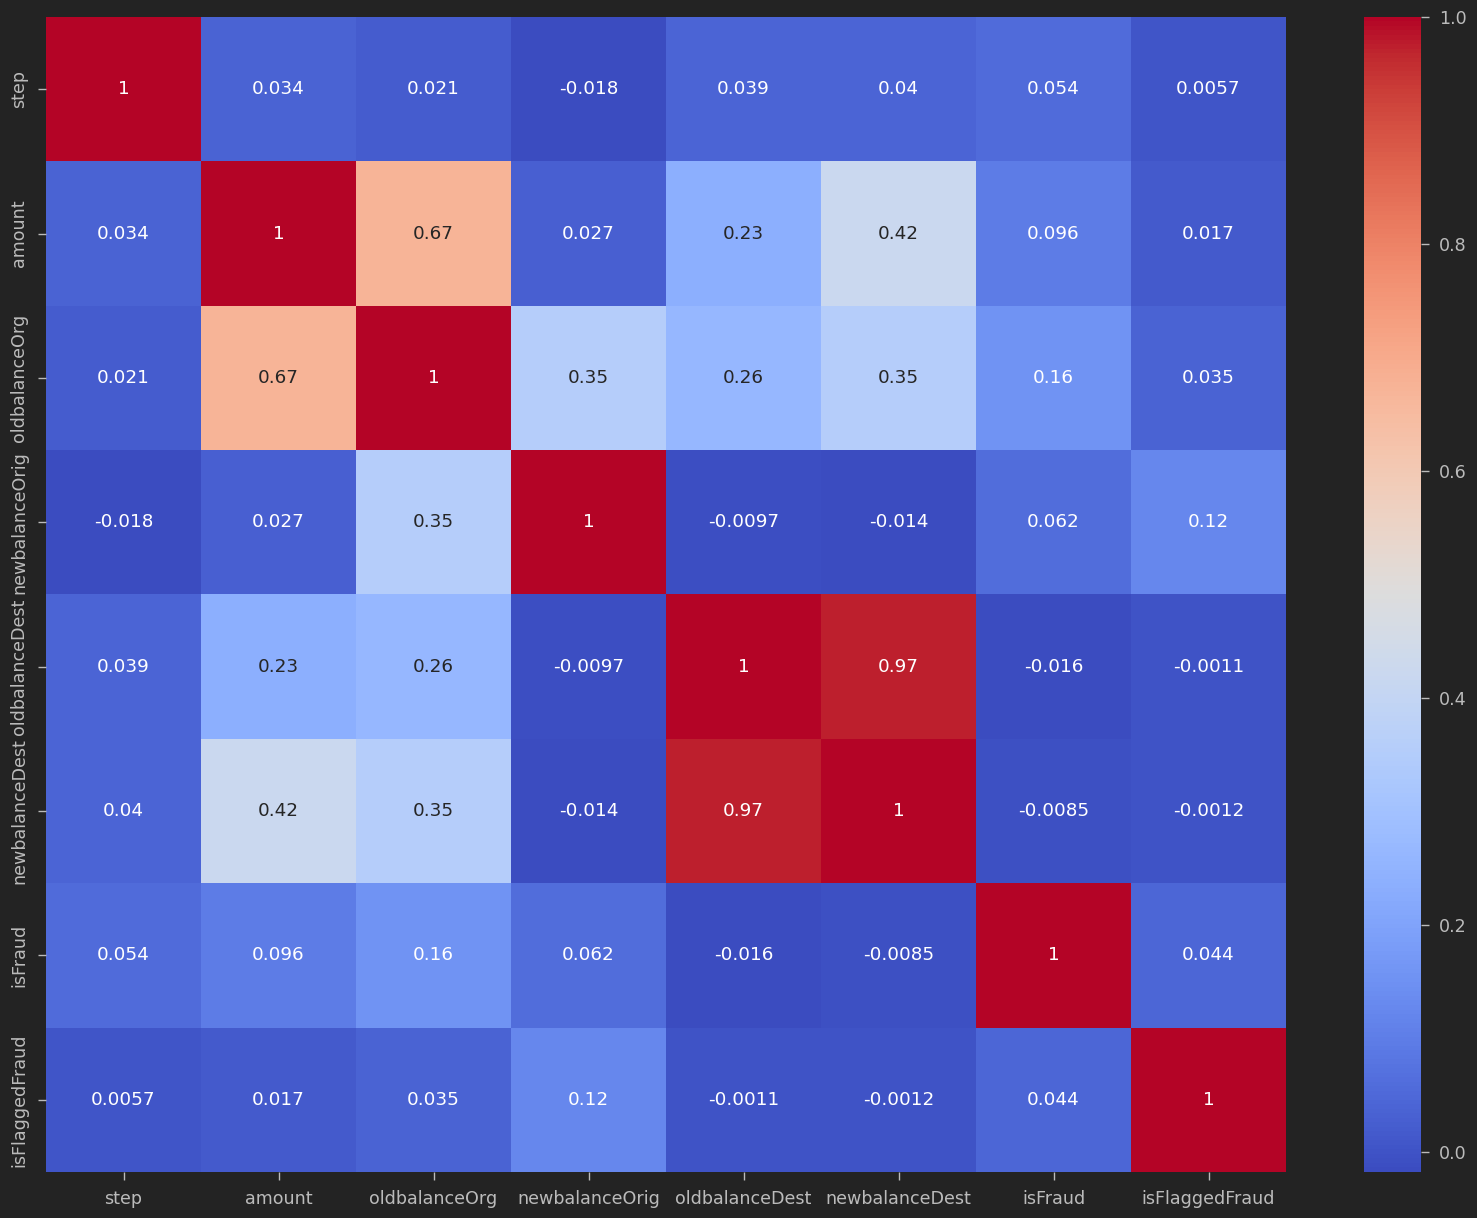

In [31]:
#plotting the heatmap 
plt.figure(figsize=(20,15))
sns.heatmap(data[["step", "amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest", "isFraud", "isFlaggedFraud"]].corr(),annot=True,cmap="coolwarm")


## Conclusion

The fraudster is trying to take control of the victim accounts and trying to empty the victim balance with 2 methods:
1. By Transfer it to several accounts as mule to temporarily receive the money before its cash out of the system
2. Directly using merchant to cash out the maximum balance allowed.

a fraud transaction were only found in *Transfer and Cashout* types. It is proven that the fraudster modus operandi after taking over the victim account is to Transfer it into temporarily account then cash it out.

While there are possibilities that the fraudster would cash out the victims balance on the merchants, but there were no transactions deeemed as fraud when the destination is a merchant.

The nameDest who deemed as Fraud never shows up as nameOrigin in any types of transaction that were also deemed as fraud. Means the fraudster likely to transfer it several times to other temporarily accounts before cash out the balance.

In 30 days of span, below 100 hours there were moments no transaction were made on non-fraud transactions. While on fraud transactions, there were no moments like that.

In [32]:
data1= data[["step", "amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest", "isFraud", "isFlaggedFraud", "type", "nameOrig", "nameDest"]]


In [33]:
data1.shape

(2048815, 11)

### 2. Encoding the categorical data

In [34]:
# Encode the types transaction

data1['Type_encode'] = data1['type'].map({'TRANSFER': 0, 'CASH_OUT': 1})

data1.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type,nameOrig,nameDest,Type_encode
2,1,181.00,181.0,0.0,0.0,0.00,1,0,TRANSFER,C1305486145,C553264065,0
3,1,181.00,181.0,0.0,21182.0,0.00,1,0,CASH_OUT,C840083671,C38997010,1
15,1,229133.94,15325.0,0.0,5083.0,51513.44,0,0,CASH_OUT,C905080434,C476402209,1
19,1,215310.30,705.0,0.0,22425.0,0.00,0,0,TRANSFER,C1670993182,C1100439041,0
24,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,0,TRANSFER,C1984094095,C932583850,0


In [35]:
# encoding type

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data1['type']= le.fit_transform(data1['type'].values)

In [36]:
# encoding nameOrig

le = LabelEncoder()
data1['nameOrig']= le.fit_transform(data1['nameOrig'].values)

In [37]:
# encoding nameDest
le = LabelEncoder()
data1['nameDest']= le.fit_transform(data1['nameDest'].values)

In [38]:
data1.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type,nameOrig,nameDest,Type_encode
2,1,181.00,181.0,0.0,0.0,0.00,1,0,1,322489,385480,0
3,1,181.00,181.0,0.0,21182.0,0.00,1,0,0,1878248,343388,1
15,1,229133.94,15325.0,0.0,5083.0,51513.44,0,0,0,1946976,365643,1
19,1,215310.30,705.0,0.0,22425.0,0.00,0,0,1,709592,26098,0
24,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,0,1,1042051,484189,0


### 3.Feature selection based on feature importance

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
X = data1.drop(columns=['isFraud'])
Y = data1['isFraud']

randomState = 5
np.random.seed(randomState)

trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, \
                                                random_state = randomState)

In [41]:
# Long computation in this cell (~1.8 minutes)
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, \
                n_jobs = 4)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {}'.format(average_precision_score(testY, \
                                              probabilities[:, 1])))

AUPRC = 0.8696266670909063


#### Feature Importance

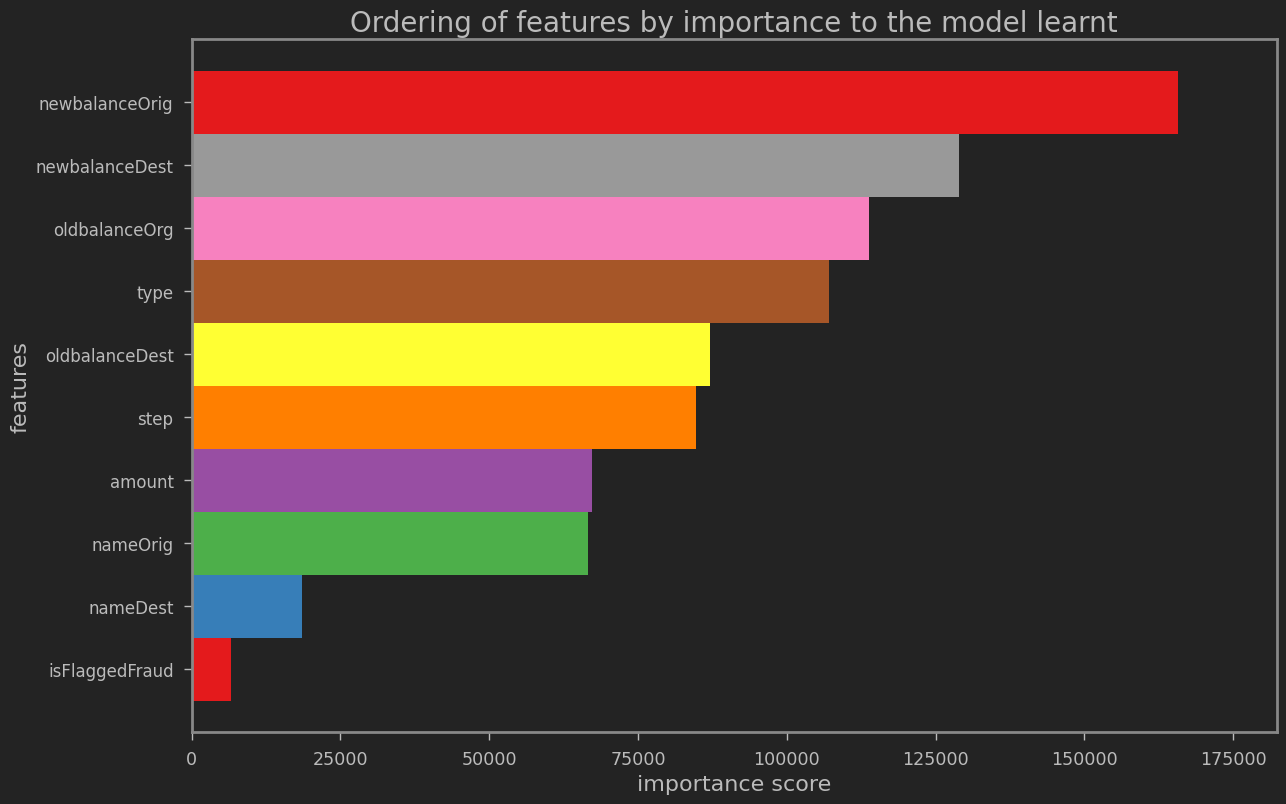

In [42]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);

In [43]:
# keeping the important features and removing others
data1= data1[["step", "amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest", "isFraud", "isFlaggedFraud", "type", "nameOrig", "nameDest"]]

### Imbalanced dataset

isFraud Distribution amount: 
0    2040602
1       8213
Name: isFraud, dtype: int64


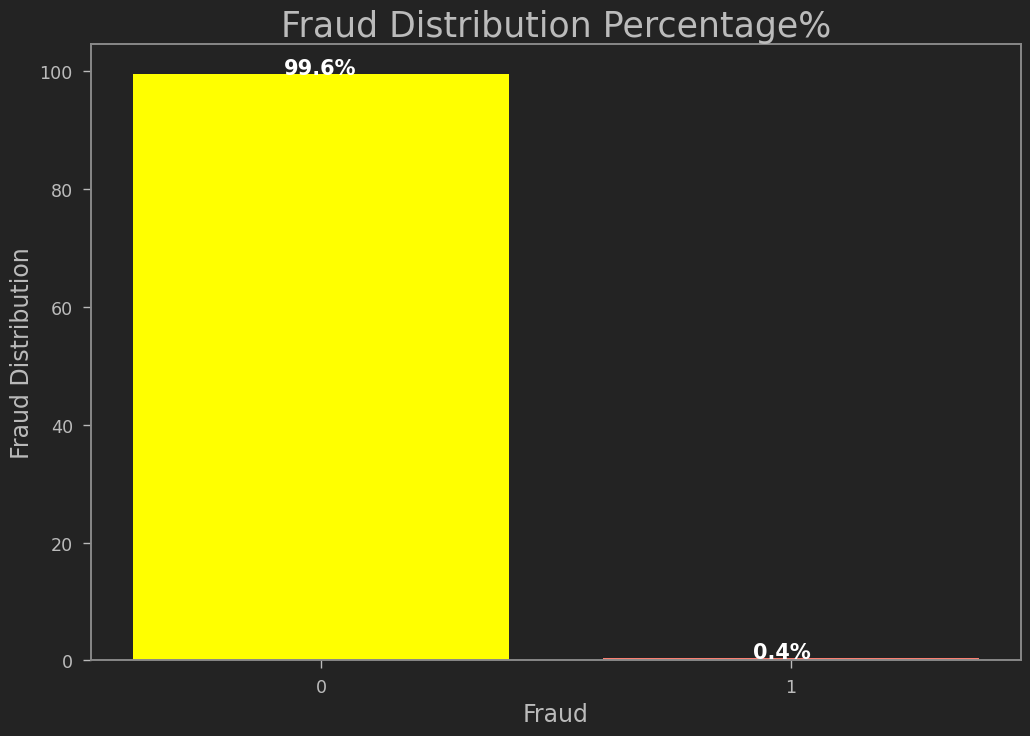

In [44]:
# Checking the distribution of target columns
print(f"isFraud Distribution amount: \n{data['isFraud'].value_counts()}")

Fraud = round(data['isFraud'].value_counts(normalize= True) * 100,2)
x = Fraud.index
y = Fraud.values

plt.figure(figsize=(12,8))  
plt.bar(x, y,color=['yellow','salmon']);
plt.xlabel('Fraud',fontdict={'fontsize': 17})
plt.ylabel('Fraud Distribution',fontdict={'fontsize': 17}) 
plt.title('Fraud Distribution Percentage%', fontdict={'fontsize': 25})
for i, v in enumerate(y):   
    plt.text(i-0.08,v+0,f'{v}%',fontweight='bold',color='white',fontsize=15)
plt.xticks([0,1])
plt.show()

This dataset fraud detection is imbalance, only 0.17% from 4.8 million transactions where tagged/classified as Fraud. Unbalaced dataset is not good for any classification model and will give inaccurate information. 

We can solve this problem either by :
- Undersampling
- Ovesampling


### 4. Under Sampling

In [45]:
data1 = data1.sample(frac=1)

# amount of fraud classes 8213 rows.
fraud_df = data1.loc[data1['isFraud'] == 1]
non_fraud_df = data1.loc[data1['isFraud'] == 0][:8213]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
under_df = normal_distributed_df.sample(frac=1, random_state=42)

under_df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type,nameOrig,nameDest
3971607,370,250787.65,236302.00,0.0,0.0,250787.65,0,0,0,151562,295910
508428,36,92502.22,10621.00,0.0,0.0,92502.22,0,0,0,1990380,206043
767912,66,2322909.69,2322909.69,0.0,0.0,0.00,1,0,1,841533,412709
4712634,564,55828.87,55828.87,0.0,0.0,55828.87,1,0,0,179824,459234
3124626,302,43235.71,43235.71,0.0,0.0,0.00,1,0,1,30447,125227


isFraud Distribution amount: 
0    8213
1    8213
Name: isFraud, dtype: int64


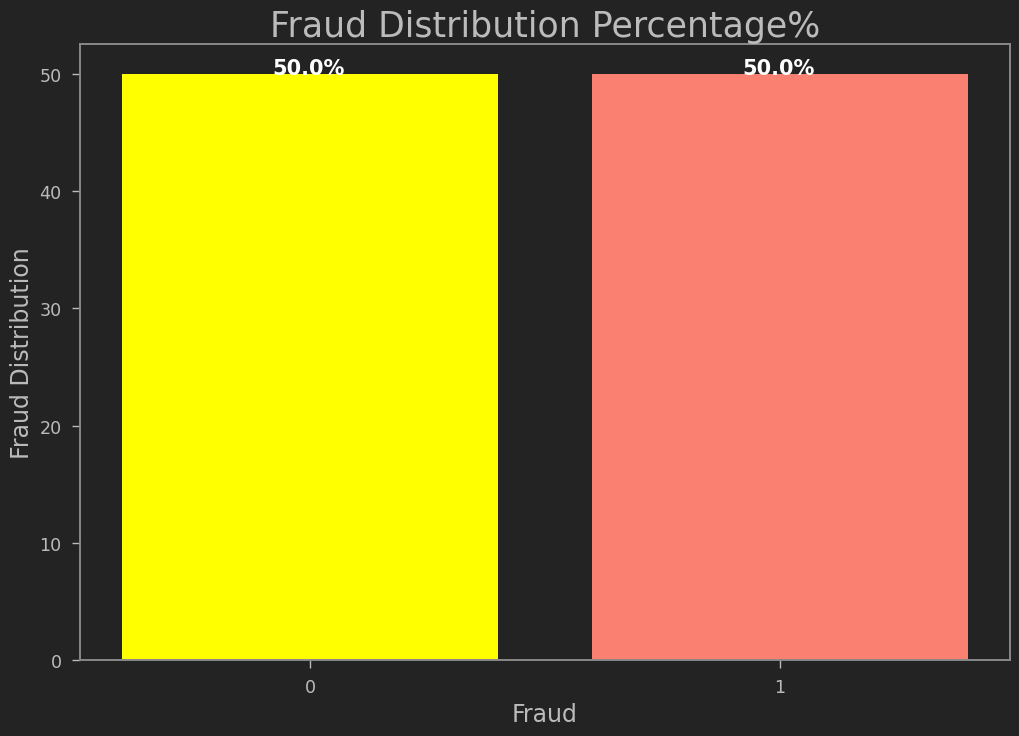

In [46]:
# Checking the distribution of target columns
print(f"isFraud Distribution amount: \n{under_df['isFraud'].value_counts()}")

Fraud = round(under_df['isFraud'].value_counts(normalize= True) * 100,2)
x = Fraud.index
y = Fraud.values

plt.figure(figsize=(12,8))  
plt.bar(x, y,color=['yellow','salmon']);
plt.xlabel('Fraud',fontdict={'fontsize': 17})
plt.ylabel('Fraud Distribution',fontdict={'fontsize': 17}) 
plt.title('Fraud Distribution Percentage%', fontdict={'fontsize': 25})
for i, v in enumerate(y):   
    plt.text(i-0.08,v+0,f'{v}%',fontweight='bold',color='white',fontsize=15)
plt.xticks([0,1])
plt.show()


We are only taking 8213 rows from majority class to make it equal in number with the minority class. 

### 5. Over- Sampling (SMOTE)

SMOTE stands for Synthetic Minority Over-sampling Technique. Unlike Random UnderSampling, SMOTE creates new synthetic points in order to have an equal balance of the classes.

In [47]:
#import the module 
from imblearn.over_sampling import SMOTE

data1 = data1.sample(frac=1)

smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(data1.drop(columns=['isFraud']), data1.isFraud)

print('Original dataset shape', len(data1))
print('Resampled dataset shape', len(y_smote))

#creating new dataframe 
over_df = x_smote
over_df['isFraud'] = y_smote


Original dataset shape 2048815
Resampled dataset shape 4081204


isFraud Distribution amount: 
0    2040602
1    2040602
Name: isFraud, dtype: int64


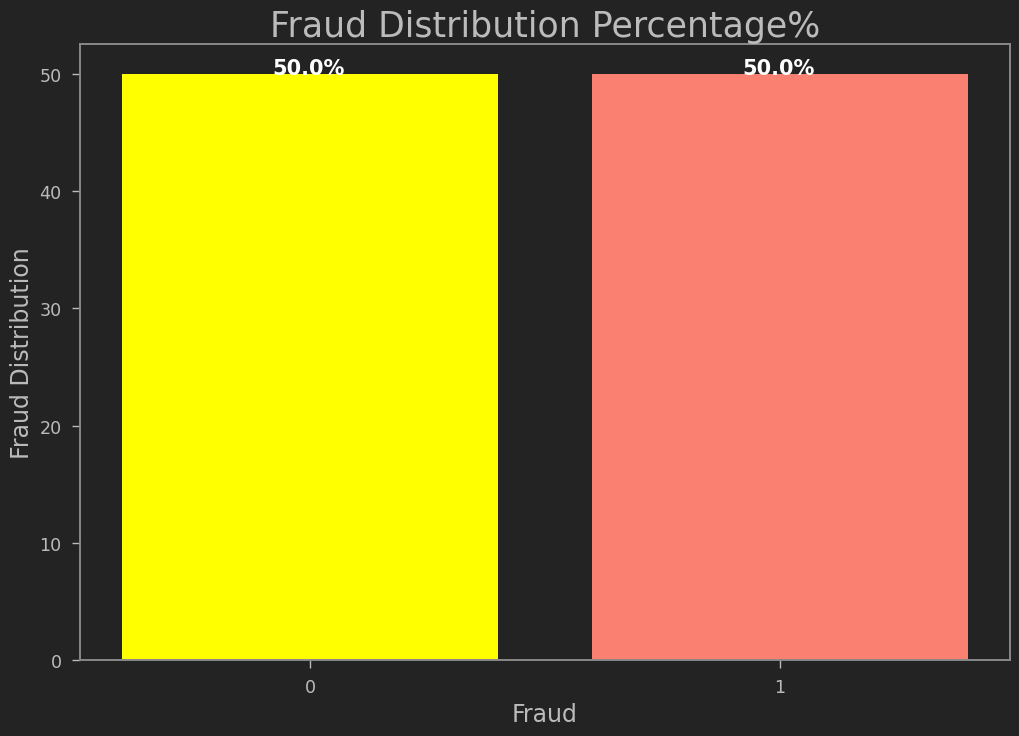

In [48]:
# Checking the distribution of target columns
print(f"isFraud Distribution amount: \n{over_df['isFraud'].value_counts()}")

Fraud = round(over_df['isFraud'].value_counts(normalize= True) * 100,2)
x = Fraud.index
y = Fraud.values

plt.figure(figsize=(12,8))  
plt.bar(x, y,color=['yellow','salmon']);
plt.xlabel('Fraud',fontdict={'fontsize': 17})
plt.ylabel('Fraud Distribution',fontdict={'fontsize': 17}) 
plt.title('Fraud Distribution Percentage%', fontdict={'fontsize': 25})
for i, v in enumerate(y):   
    plt.text(i-0.08,v+0,f'{v}%',fontweight='bold',color='white',fontsize=15)
plt.xticks([0,1])
plt.show()


SMOTE over samples the minority class and make it equal in number with majority class. As you can see from the viz, now both the classses have equal data.

### 5. Feature Scaling Standardization 
               Logistic regression

In [49]:
#importing library
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
'''standardising under sampled data''' 
# Splitting the independent and dependent variables
i_data = under_df.drop(columns=['isFraud'])
under_response = under_df.isFraud
 
# standardization 
under_scale = sc.fit_transform(i_data) 
print(under_scale)

[[ 0.32713982 -0.33621604 -0.25058683 ... -0.71980178 -1.47189441
   0.29688065]
 [-1.399585   -0.42010805 -0.33621845 ... -0.71980178  1.63635101
  -0.3260326 ]
 [-1.24448996  0.76201824  0.54114843 ...  1.38927136 -0.30560215
   1.1064731 ]
 ...
 [ 1.25771008 -0.45778256 -0.33212135 ...  1.38927136  0.92098996
  -0.11802517]
 [ 2.08488365  4.83091167 10.06324404 ...  1.38927136 -1.7205888
   0.25398852]
 [-0.42248623 -0.36994912 -0.33224499 ... -0.71980178  0.26601495
   0.20589776]]


In [50]:
'''standardising over sampled data'''
sc = StandardScaler()

# Splitting the independent and dependent variables
i_data = under_df.drop(columns=['isFraud'])
over_response = under_df.isFraud
 
# standardization 
over_scale = sc.fit_transform(i_data) 
print(over_scale)

[[ 0.32713982 -0.33621604 -0.25058683 ... -0.71980178 -1.47189441
   0.29688065]
 [-1.399585   -0.42010805 -0.33621845 ... -0.71980178  1.63635101
  -0.3260326 ]
 [-1.24448996  0.76201824  0.54114843 ...  1.38927136 -0.30560215
   1.1064731 ]
 ...
 [ 1.25771008 -0.45778256 -0.33212135 ...  1.38927136  0.92098996
  -0.11802517]
 [ 2.08488365  4.83091167 10.06324404 ...  1.38927136 -1.7205888
   0.25398852]
 [-0.42248623 -0.36994912 -0.33224499 ... -0.71980178  0.26601495
   0.20589776]]


## Modeling

### Performance Metrics

Precision is a good metric to use when the costs of false positive(FP) is high.

Precision = TP / (TP + FP)

Recall is a good metric to use when the cost associated with false negative(FN) is high.

Recall = TP / (TP + FN)

F1-score is a weighted average of precision and recall. Thus, it considers FP and FN. This metric is very useful when we have uneven class distribution, as it seeks a balance between precision and recall.

F1-score = 2 * (precision * recall) / (precision + recall)

## Confusion Matrix
Confusion Matrix is a performance measurement for machine learning classification problem where output can be two or more classes. It is a table with 4 different combinations of predicted and actual values.

![image.png](attachment:image.png)

#### Model Will Focusing on Recall from isFraud 1
We want to avoid Error on False Negative ==> Actual Fraud but detected/predicted as Non-Fraud

## Importing packages for modeling

In [51]:
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


### Train Test Split

We want to see how models are performing on undersampled adata as well as over sampled data.

In [52]:
'''For under-sampled data'''
under_X = under_scale
under_y = under_response 

#taking test sixe as 20%
under_X_train, under_X_test, under_y_train, under_y_test = train_test_split(under_X, under_y , test_size=.2,random_state=21)



In [53]:
'''For over-sampled data'''
over_X = over_scale
over_y = over_response 


#taking test sixe as 20%
over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y , test_size=.2, random_state=21)



In [54]:
# creating an evaluation matrix that will be used to do model comparision 
# towards the end of this notebook.

def evaluationMetrics(y_test, y_pred):
    f1.append(f1_score(y_test,y_pred))
    prec.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    acc.append(accuracy_score(y_test, y_pred))

In [55]:
metric = pd.DataFrame(index = ['Logistic Regression Undersampled', 'Logistic Regression OverSampling',
                               'Random Forest Classifier Undersampling', 'Random Forest Classifier TOversampling',
                               'XGBoost Classifier Undersampling', 'XGBoost Classifier Oversampling',
                              'Logistic Regression Tuned', 'Random Forest Tuned', 'XGBoost Classifier Tuned']) 

f1 = []
prec = []
recall = []
acc = []

## Model-1 : Logistic Regression Classifier

#### Using Under-sampled Data

In [56]:
underModelLR = LogisticRegression()

'''Model for undersampled Data'''
#training
underModelLR.fit(under_X_train,under_y_train)

#testing
under_y_LR = underModelLR.predict(under_X_test)
under_y_train_LR = underModelLR.predict(under_X_train)

#generating classification report
print(classification_report(under_y_test, under_y_LR))
evaluationMetrics(under_y_test,under_y_LR)
print(f"Train Score: {underModelLR.score(under_X_train, under_y_train)}\nTest Score: {underModelLR.score(under_X_test, under_y_test)}")

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1686
           1       0.90      0.81      0.85      1600

    accuracy                           0.86      3286
   macro avg       0.86      0.86      0.86      3286
weighted avg       0.86      0.86      0.86      3286

Train Score: 0.8613394216133942
Test Score: 0.8603164942178941


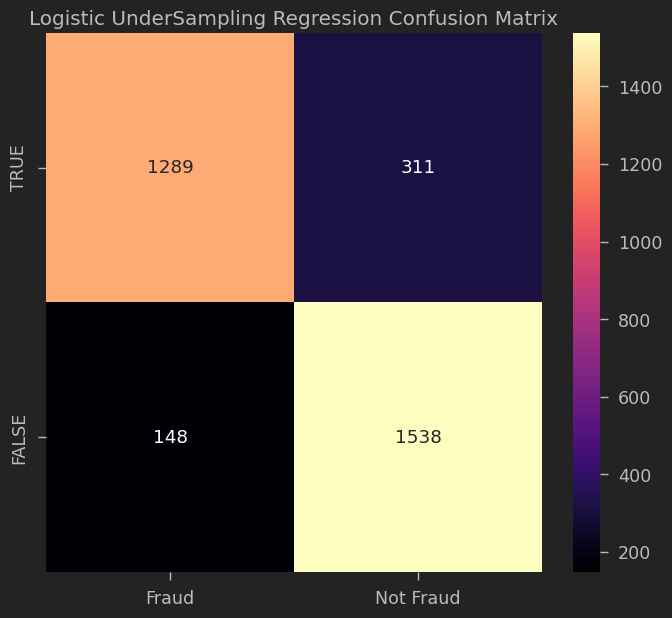

In [57]:
# displying confusion matrix
cm_LR = confusion_matrix(under_y_test, under_y_LR, labels=[1 , 0])
df_cm_LR = pd.DataFrame(data=cm_LR,index=["TRUE" ,"FALSE"], columns=["Fraud", "Not Fraud"])
sns.heatmap(df_cm_LR, annot=True, fmt='d',cmap='magma');
plt.title('Logistic UnderSampling Regression Confusion Matrix')
plt.show()

#### Using Over-sampled Data

In [58]:
overModelLR = LogisticRegression()

'''Model for oversampled Data'''
#training
overModelLR.fit(over_X_train,over_y_train)

#testing
over_y_LR = overModelLR.predict(over_X_test)
over_y_train_LR = overModelLR.predict(over_X_train)

#generating classification report
print(classification_report(over_y_test, over_y_LR))
evaluationMetrics(over_y_test,over_y_LR)
print(f"Train Score: {overModelLR.score(over_X_train, over_y_train)}\nTest Score: {overModelLR.score(over_X_test, over_y_test)}")

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1686
           1       0.90      0.81      0.85      1600

    accuracy                           0.86      3286
   macro avg       0.86      0.86      0.86      3286
weighted avg       0.86      0.86      0.86      3286

Train Score: 0.8613394216133942
Test Score: 0.8603164942178941


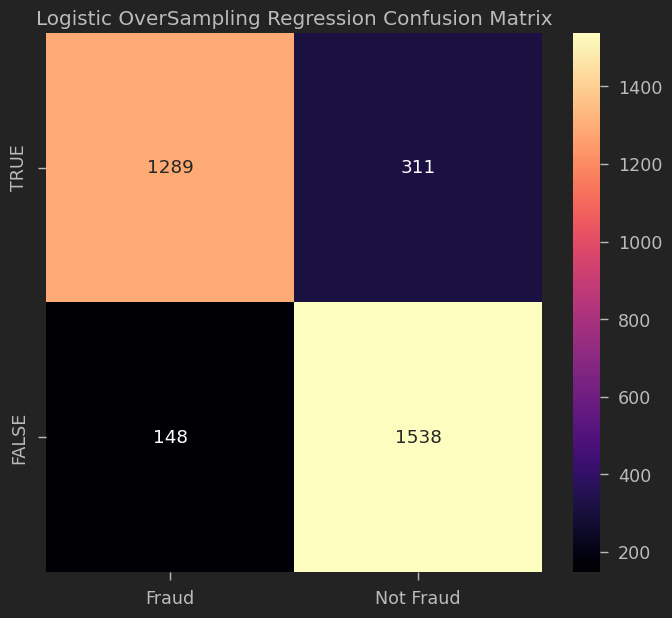

In [59]:
# displying confusion matrix
cm_LR = confusion_matrix(over_y_test, over_y_LR, labels=[1 , 0])
df_cm_LR = pd.DataFrame(data=cm_LR,index=["TRUE" ,"FALSE"], columns=["Fraud", "Not Fraud"])
sns.heatmap(df_cm_LR, annot=True, fmt='d',cmap='magma');
plt.title('Logistic OverSampling Regression Confusion Matrix')
plt.show()

By comparing the classification score of both under sampled and over sampled data we can see model is performing better with oversampled data so we will move on to tune the model using oversampled data. 

### Logestic Regression Hyper Parameter Tuning

In [60]:
LR_tuned = LogisticRegression()

#set the parmeter
param_LR = {'penalty':['l1','l2'], 'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

In [61]:
# using RandomizedSerchCV for hyperparameter tuning

model_LR_Tuned =RandomizedSearchCV(LogisticRegression(), param_LR, scoring = 'accuracy', n_jobs = -1, verbose = 3, cv = 3)


In [62]:
model_LR_Tuned.fit(over_X_train, over_y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver lb

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   n_iter=10, n_jobs=-1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100,
                                              1000],
                                        'penalty': ['l1', 'l2']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='accuracy', verbose=3)

In [63]:
log_reg = model_LR_Tuned.best_estimator_
model_LR_Tuned.best_params_

{'penalty': 'l2', 'C': 10}

In [64]:
y_tuned_LR = model_LR_Tuned.predict(over_X_test)

print(classification_report(over_y_test, y_tuned_LR))
evaluationMetrics(over_y_test,y_tuned_LR)
print(f"Train Score: {model_LR_Tuned.score(over_X_train, over_y_train)}\nTest Score: {model_LR_Tuned.score(over_X_test,over_y_test)}")

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1686
           1       0.88      0.84      0.86      1600

    accuracy                           0.87      3286
   macro avg       0.87      0.87      0.87      3286
weighted avg       0.87      0.87      0.87      3286

Train Score: 0.8700913242009133
Test Score: 0.868837492391966


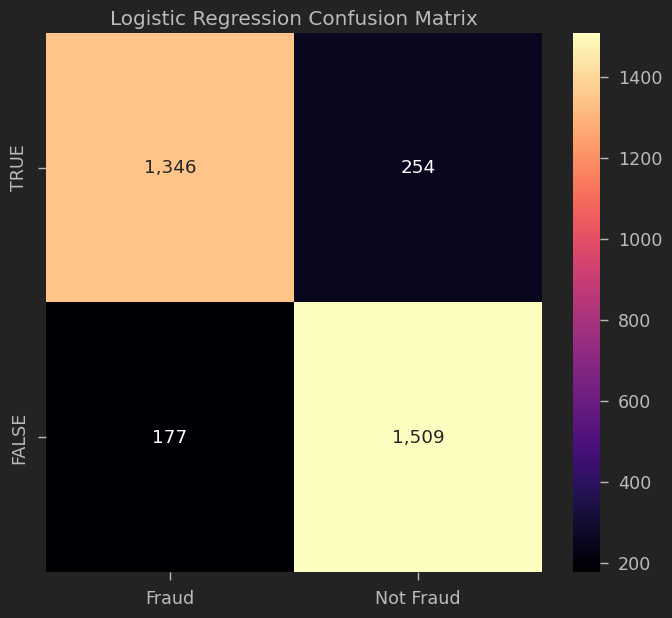

In [65]:
# displying confusion matrix
cm_LR_tuned = confusion_matrix(over_y_test, y_tuned_LR, labels=[1 , 0])
df_cm_LR_tuned = pd.DataFrame(data=cm_LR_tuned,index=["TRUE" ,"FALSE"], columns=["Fraud", "Not Fraud"])
sns.heatmap(df_cm_LR_tuned, annot=True, fmt=',d',cmap='magma');
plt.title('Logistic Regression Confusion Matrix')
plt.show()

## Model-2: Random Forest Classifier


#### Using Under-sampled Data

In [66]:
underModelRF = RandomForestClassifier()

'''Model for undersampled Data'''
#training
underModelRF.fit(under_X_train,under_y_train)

#testing
under_y_RF = underModelRF.predict(under_X_test)
under_y_train_RF = underModelRF.predict(under_X_train)

print(classification_report(under_y_test, under_y_LR))
evaluationMetrics(under_y_test,under_y_LR)
print(f"Train Score: {underModelRF.score(under_X_train, under_y_train)}\nTest Score: {underModelRF.score(under_X_test, under_y_test)}")

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1686
           1       0.90      0.81      0.85      1600

    accuracy                           0.86      3286
   macro avg       0.86      0.86      0.86      3286
weighted avg       0.86      0.86      0.86      3286

Train Score: 1.0
Test Score: 0.9470480827754109


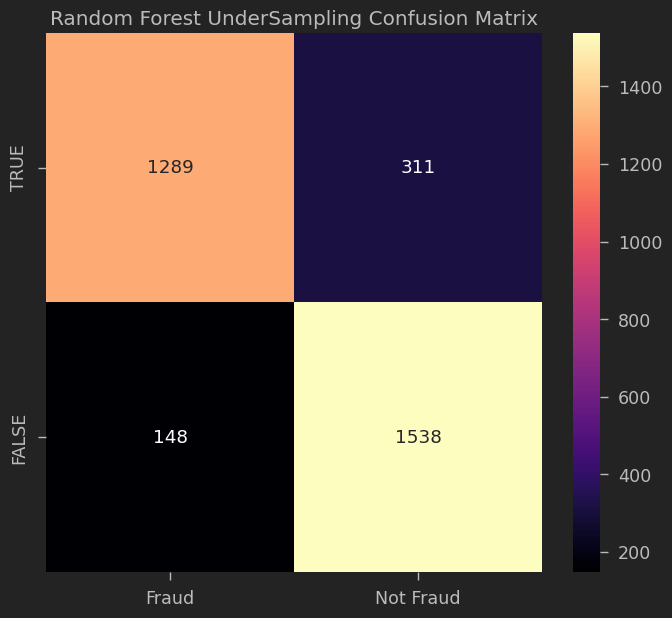

In [67]:
# displying confusion matrix
cm_RF = confusion_matrix(under_y_test, under_y_RF, labels=[1 , 0])
df_cm_RF = pd.DataFrame(data=cm_RF,index=["TRUE" ,"FALSE"], columns=["Fraud", "Not Fraud"])
sns.heatmap(df_cm_LR, annot=True, fmt='d',cmap='magma');
plt.title('Random Forest UnderSampling Confusion Matrix')
plt.show()

#### Using Over-sampled Data

In [68]:
overModelRF = RandomForestClassifier()

'''Model for oversampled Data'''
#training
overModelRF.fit(over_X_train,over_y_train)

#testing
over_y_RF = overModelRF.predict(over_X_test)
over_y_train_RF = overModelRF.predict(over_X_train)

#generating classification report
print(classification_report(over_y_test, over_y_RF))
evaluationMetrics(over_y_test,over_y_RF)
print(f"Train Score: {overModelRF.score(over_X_train, over_y_train)}\nTest Score: {overModelRF.score(over_X_test, over_y_test)}")



              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1686
           1       0.97      0.93      0.95      1600

    accuracy                           0.95      3286
   macro avg       0.95      0.95      0.95      3286
weighted avg       0.95      0.95      0.95      3286

Train Score: 1.0
Test Score: 0.9491783323189288


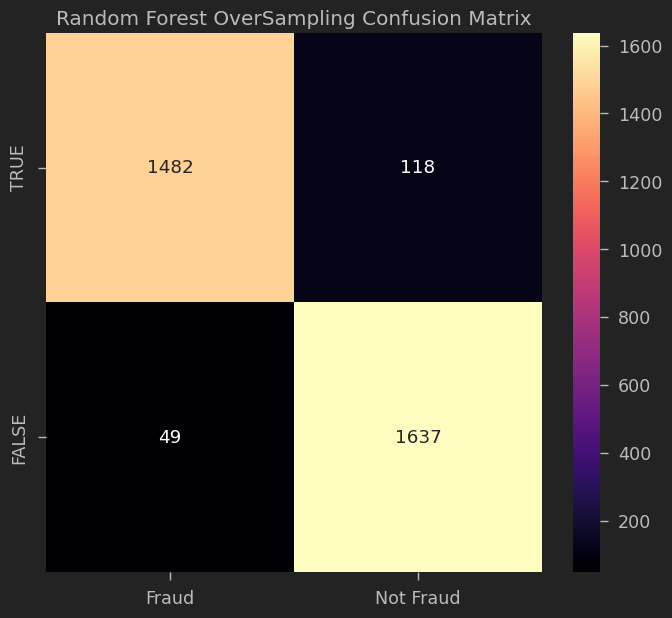

In [69]:
# displying confusion matrix
cm_RF = confusion_matrix(over_y_test, over_y_RF, labels=[1 , 0])
df_cm_RF = pd.DataFrame(data=cm_RF,index=["TRUE" ,"FALSE"], columns=["Fraud", "Not Fraud"])
sns.heatmap(df_cm_RF, annot=True, fmt='d',cmap='magma');
plt.title('Random Forest OverSampling Confusion Matrix')
plt.show()

By comparing the classification score of both under sampled and over sampled data we can see model is performing better with oversampled data so we will move on to tune the model using oversampled data. 

#### Random Forest Hyper Parameter Tuning

In [70]:
RF_tuned = RandomForestClassifier()

#set the parmeter
param_RF = {"n_estimators" : [100,500],
          "max_depth" : [1,5,7],
          "min_samples_split" : [10,8],
          "min_samples_leaf" : [2,4,5,3],
          "max_features" : ['auto',.75,.8]}


In [71]:
# using RandomizedSerchCV for hyperparameter tuning
model_RF_Tuned = RandomizedSearchCV(estimator=RF_tuned, param_distributions=param_RF,cv=5, n_jobs=-1, verbose=1, scoring='recall')
model_RF_Tuned.fit(over_X_train, over_y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='sqrt',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=100,
                                                    n_jobs=None,
                                                    oob_score=False,
                                                    random_state=None,
                                                    verbose=0,
                                                    warm_start=False),
                   n_iter=10, n_jobs=-1,
                   param_distributions={'max_depth': [1, 5, 7],
                                        'max_features': ['auto', 0.75, 0.8],
                                        'min_samples_leaf': [2, 4, 5, 3],
                                        'min_samples_split': [10, 8],
                                        'n_estimators': [100, 500]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='recall', verbose=1)

In [72]:
tree_clf = model_RF_Tuned.best_estimator_
model_RF_Tuned.best_params_

{'n_estimators': 500,
 'min_samples_split': 10,
 'min_samples_leaf': 3,
 'max_features': 0.8,
 'max_depth': 7}

In [73]:
y_tuned_RF = model_RF_Tuned.predict(over_X_test)

print(classification_report(over_y_test, y_tuned_RF))
evaluationMetrics(over_y_test,y_tuned_RF)
print(f"Train Score: {model_RF_Tuned.score(over_X_train, over_y_train)}\nTest Score: {model_RF_Tuned.score(over_X_test, over_y_test)}")

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1686
           1       0.97      0.90      0.93      1600

    accuracy                           0.93      3286
   macro avg       0.94      0.93      0.93      3286
weighted avg       0.94      0.93      0.93      3286

Train Score: 0.8997429305912596
Test Score: 0.896875


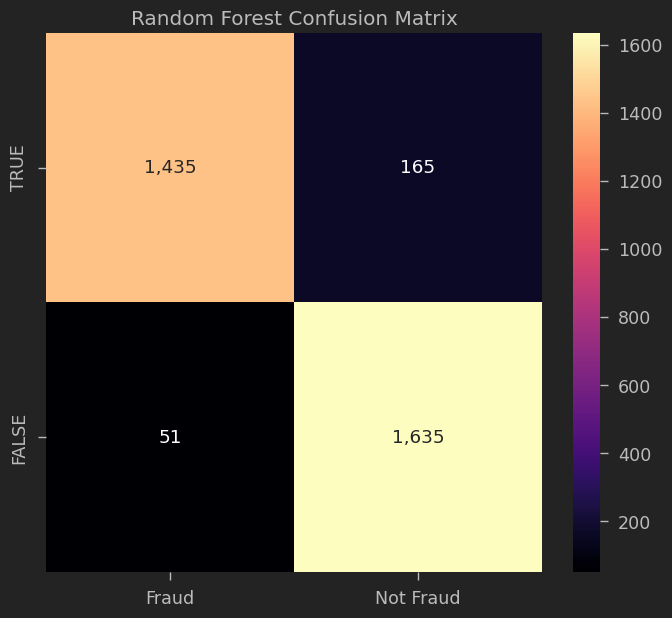

In [74]:
cm_RF_tuned = confusion_matrix(over_y_test, y_tuned_RF, labels=[1 , 0])
df_cm_RF_tuned = pd.DataFrame(data=cm_RF_tuned,index=["TRUE" ,"FALSE"], columns=["Fraud", "Not Fraud"])
sns.heatmap(df_cm_RF_tuned, annot=True, fmt=',d',cmap='magma');
plt.title('Random Forest Confusion Matrix')
plt.show()

## Model-3 : XGBoost Classifier

#### Using Under-sampled Data

In [75]:
underModelXGB = XGBClassifier()

'''Model for undersampled Data'''
#training
underModelXGB.fit(under_X_train,under_y_train)

#testing
under_y_XGB = underModelXGB.predict(under_X_test)
under_y_train_XGB = underModelXGB.predict(under_X_train)

#generating classification report
print(classification_report(under_y_test, under_y_LR))
evaluationMetrics(under_y_test,under_y_XGB)
print(f"Train Score: {underModelXGB.score(under_X_train, under_y_train)}\nTest Score: {underModelXGB.score(under_X_test, under_y_test)}")

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1686
           1       0.90      0.81      0.85      1600

    accuracy                           0.86      3286
   macro avg       0.86      0.86      0.86      3286
weighted avg       0.86      0.86      0.86      3286

Train Score: 0.9937595129375951
Test Score: 0.9537431527693244


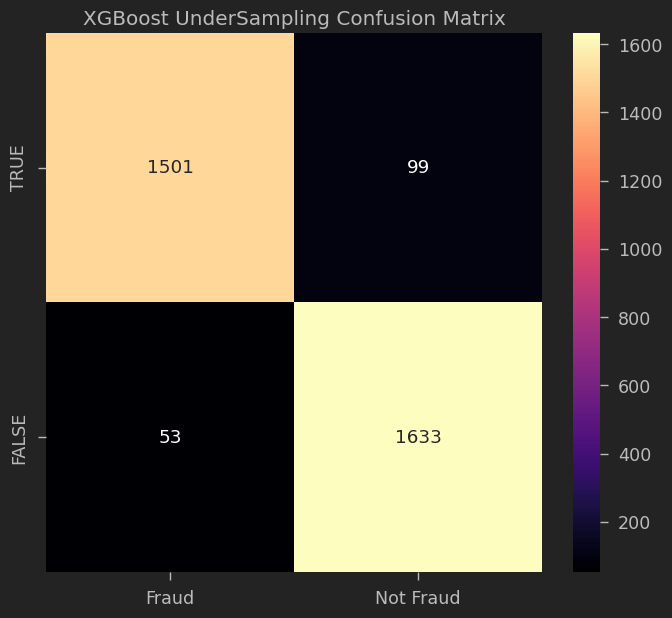

In [76]:
cm_XGB = confusion_matrix(under_y_test, under_y_XGB, labels=[1 , 0])
df_cm_XGB = pd.DataFrame(data=cm_XGB,index=["TRUE" ,"FALSE"], columns=["Fraud", "Not Fraud"])
sns.heatmap(df_cm_XGB, annot=True, fmt='d',cmap='magma');
plt.title('XGBoost UnderSampling Confusion Matrix')
plt.show()

In [121]:
import shap


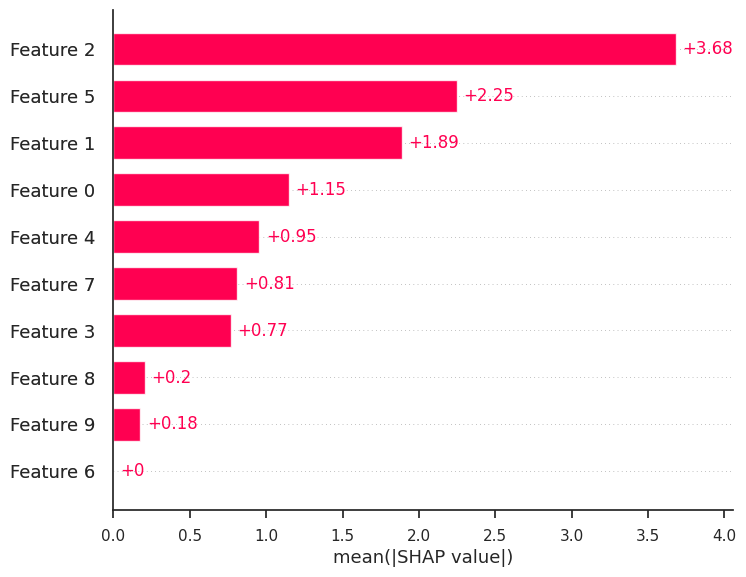

In [116]:
# generate SHAP values
explainer = shap.TreeExplainer(underModelXGB)
shap_values = explainer.shap_values(under_X_train)

# create a SHAP Explanation object
shap_exp = shap.Explanation(values=shap_values, 
                            base_values=explainer.expected_value,
                            data=under_X_train)

# plot SHAP bar plot
shap.plots.bar(shap_exp)

#### Using Over-sampled Data

In [77]:
overModelXGB = XGBClassifier()

'''Model for oversampled Data'''
#training
overModelXGB.fit(over_X_train,over_y_train)

#testing
over_y_XGB = overModelXGB.predict(over_X_test)
over_y_train_XGB = overModelXGB.predict(over_X_train)

#generating classification report
print(classification_report(over_y_test, over_y_XGB))
evaluationMetrics(over_y_test,over_y_XGB)
print(f"Train Score: {overModelXGB.score(over_X_train, over_y_train)}\nTest Score: {overModelXGB.score(over_X_test, over_y_test)}")


              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1686
           1       0.97      0.94      0.95      1600

    accuracy                           0.95      3286
   macro avg       0.95      0.95      0.95      3286
weighted avg       0.95      0.95      0.95      3286

Train Score: 0.9937595129375951
Test Score: 0.9537431527693244


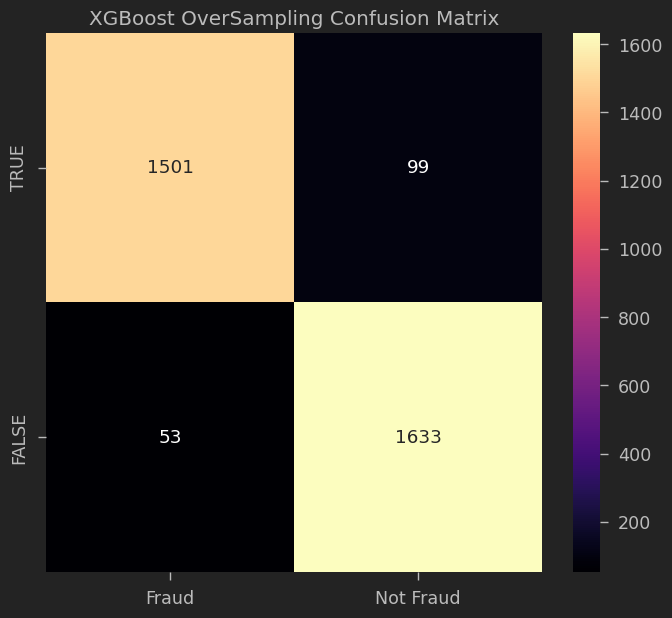

In [78]:
cm_XGB = confusion_matrix(over_y_test, over_y_XGB, labels=[1 , 0])
df_cm_XGB = pd.DataFrame(data=cm_XGB,index=["TRUE" ,"FALSE"], columns=["Fraud", "Not Fraud"])
sns.heatmap(df_cm_XGB, annot=True, fmt='d',cmap='magma');
plt.title('XGBoost OverSampling Confusion Matrix')
plt.show()

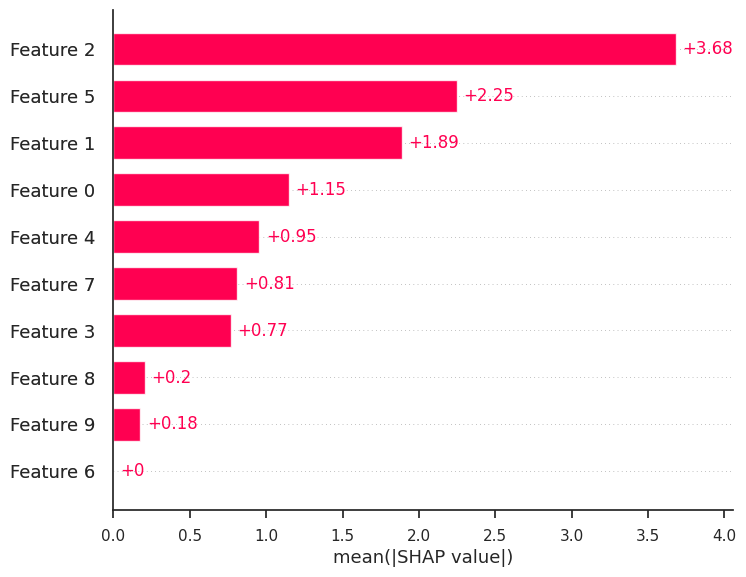

In [120]:
# generate SHAP values
explainer = shap.TreeExplainer(overModelXGB)
shap_valuess = explainer.shap_values(over_X_train)

# create a SHAP Explanation object
shap_exp1 = shap.Explanation(values=shap_valuess, 
                            base_values=explainer.expected_value,
                            data=over_X_train)

# plot SHAP bar plot
shap.plots.bar(shap_exp1)

By comparing the classification score of both under sampled and over sampled data we can see model is performing better with oversampled data so we will move on to tune the model using oversampled data. 

#### XGB Hyper Parameter Tuning

In [79]:
modelXGB = XGBClassifier()

#set the parmeter
param_XGB ={'max_depth': [1,7,1.5,6] ,
             'learning_rate': [.300000012,0.500000012] , 
             'n_estimators': [100,150,500], 
             'gamma': [0,2,.5,1], 
             'colsample_bytree': [1,.6],
             'subsample': [1,.6], 
             'reg_alpha': [0,1,.5],
             'reg_lambda': [1,.5]}

In [80]:
# using RandomizedSerchCV for hyperparameter tuning
model_XGB_tuned = RandomizedSearchCV(modelXGB, param_distributions=param_XGB, cv =2,  n_jobs=-1, verbose=1, scoring='recall')


In [81]:
XGB_Tuned = model_XGB_tuned.fit(over_X_train, over_y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
4 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.9/dist-packages/xgboost/core.py", line 620, in inner_f
    retur

In [82]:
y_tuned_XGB = XGB_Tuned.predict(over_X_test)
XGB_clf = XGB_Tuned.best_estimator_
XGB_Tuned.best_params_

{'subsample': 1,
 'reg_lambda': 0.5,
 'reg_alpha': 0,
 'n_estimators': 500,
 'max_depth': 6,
 'learning_rate': 0.300000012,
 'gamma': 0.5,
 'colsample_bytree': 0.6}

In [83]:
print(classification_report(over_y_test, y_tuned_XGB))
evaluationMetrics(over_y_test,y_tuned_XGB)
print(f"Train Score: {XGB_Tuned.score(over_X_train, over_y_train)}\nTest Score: {XGB_Tuned.score(over_X_test, over_y_test)}")

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1686
           1       0.97      0.94      0.95      1600

    accuracy                           0.96      3286
   macro avg       0.96      0.95      0.96      3286
weighted avg       0.96      0.96      0.96      3286

Train Score: 1.0
Test Score: 0.941875


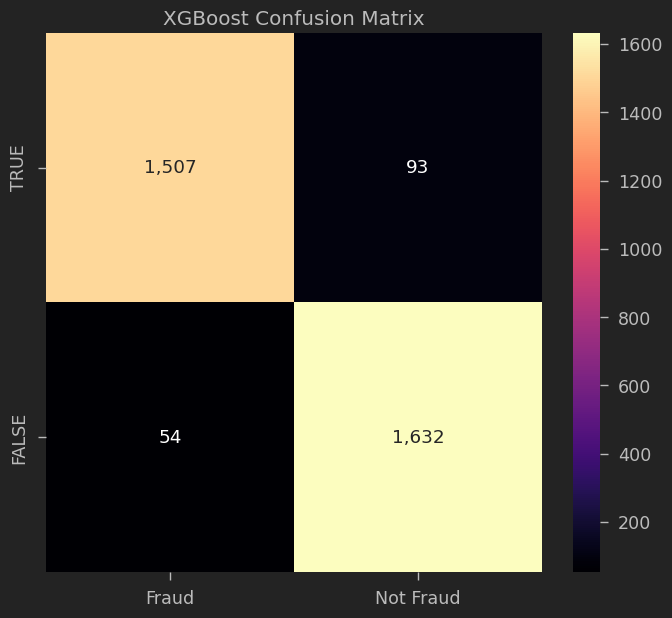

In [84]:
cm_XGB_tuned = confusion_matrix(over_y_test, y_tuned_XGB, labels=[1 , 0])
df_cm_XGB_tuned = pd.DataFrame(data=cm_XGB_tuned,index=["TRUE" ,"FALSE"], columns=["Fraud", "Not Fraud"])
sns.heatmap(df_cm_XGB_tuned, annot=True, fmt=',d',cmap='magma');
plt.title('XGBoost Confusion Matrix')
plt.show()

## Model Comparision

### Learning Curve Comparision

In [85]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator4, estimator5, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    
    # Fifth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator5, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("XGBoost Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/dist-packages/matplotlib/pyplot.py'>

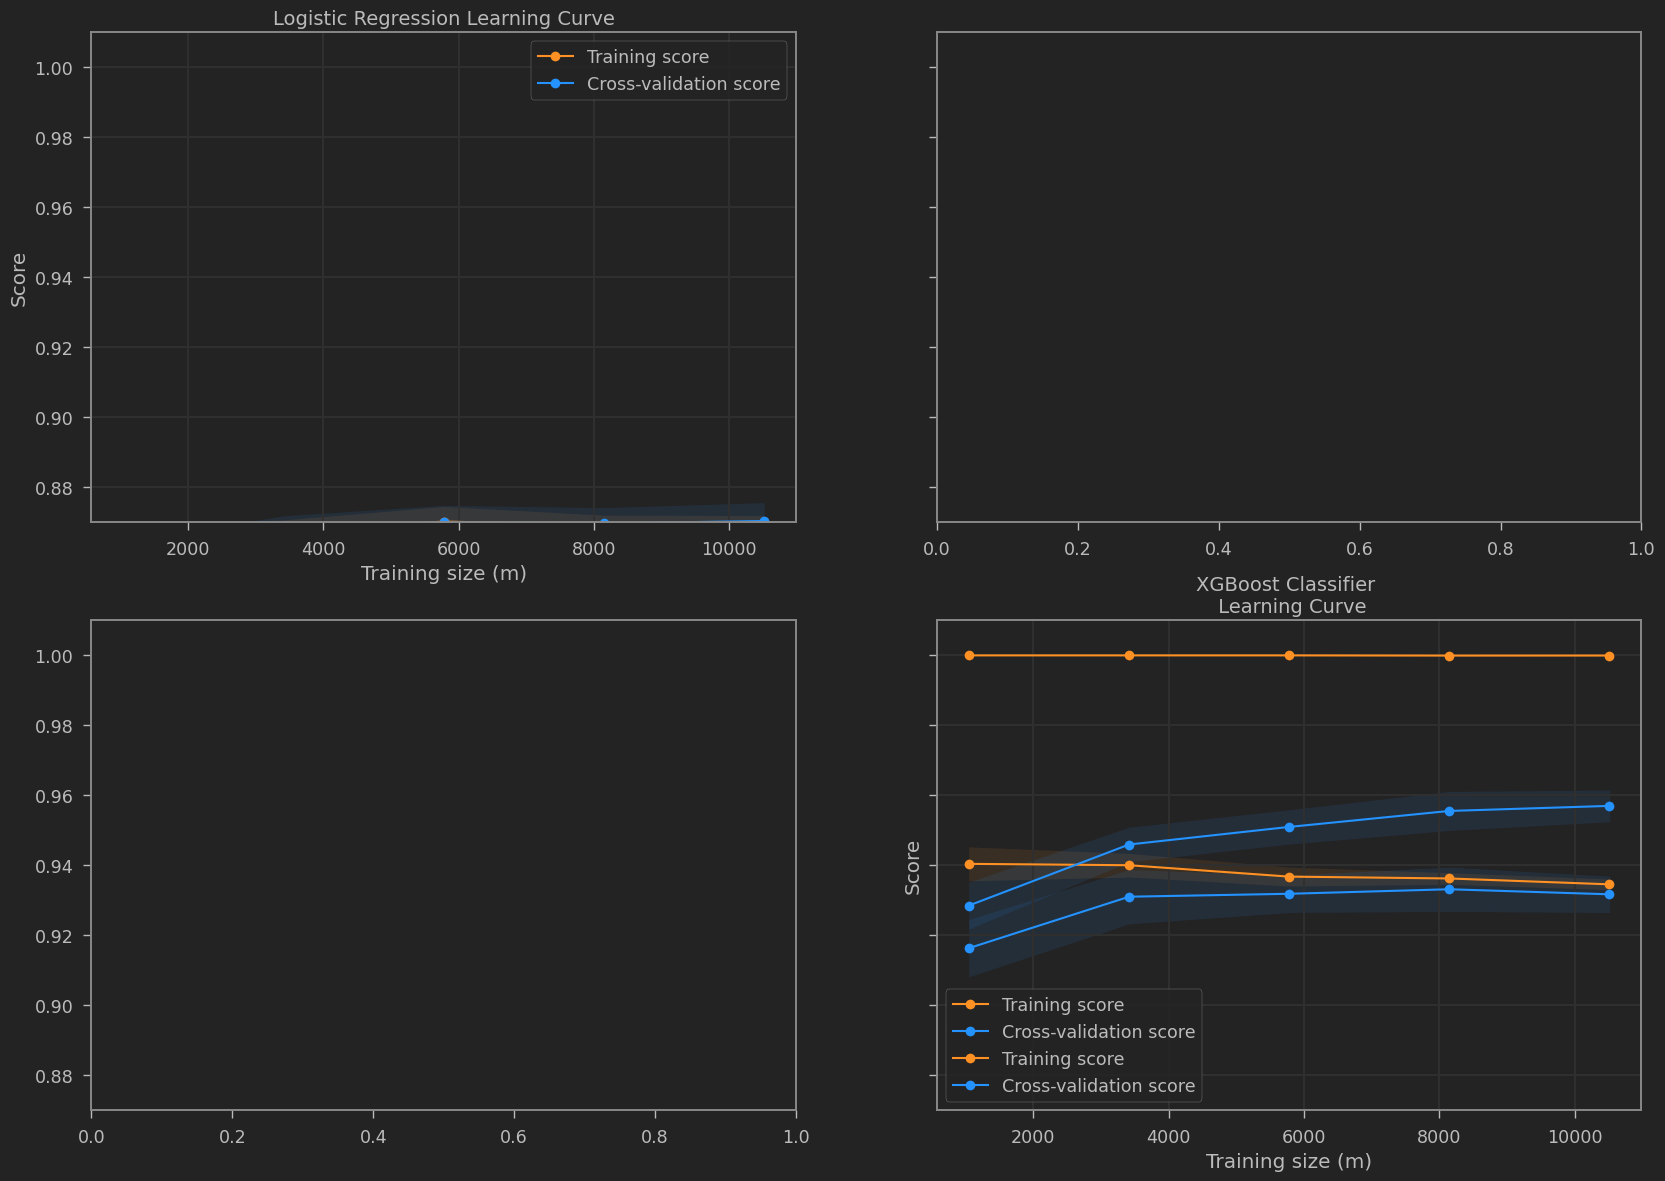

In [86]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, tree_clf, XGB_clf, over_X_train, over_y_train, (0.87, 1.01), cv=cv, n_jobs=4)

### ROC Curve Comparision

In [87]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [88]:
aucLR = roc_auc_score(over_y_test, over_y_LR)
aurRF = roc_auc_score(over_y_test, over_y_RF)
aurcXGB = roc_auc_score(over_y_test, over_y_XGB)
print('Logistic Regression: ', aucLR)
print('Decision Tree Classifier: ',aurRF)
print('XGBoost Classifier: ',aurcXGB)

Logistic Regression:  0.8589216340450773
Decision Tree Classifier:  0.9485935646500594
XGBoost Classifier:  0.953344825029656


In [89]:
print('Logistic Regression: ', roc_auc_score(over_y_test, over_y_LR))
print('Decision Tree Classifier: ',roc_auc_score(over_y_test, over_y_RF))
print('XGBoost Classifier: ',roc_auc_score(over_y_test, over_y_XGB))

Logistic Regression:  0.8589216340450773
Decision Tree Classifier:  0.9485935646500594
XGBoost Classifier:  0.953344825029656


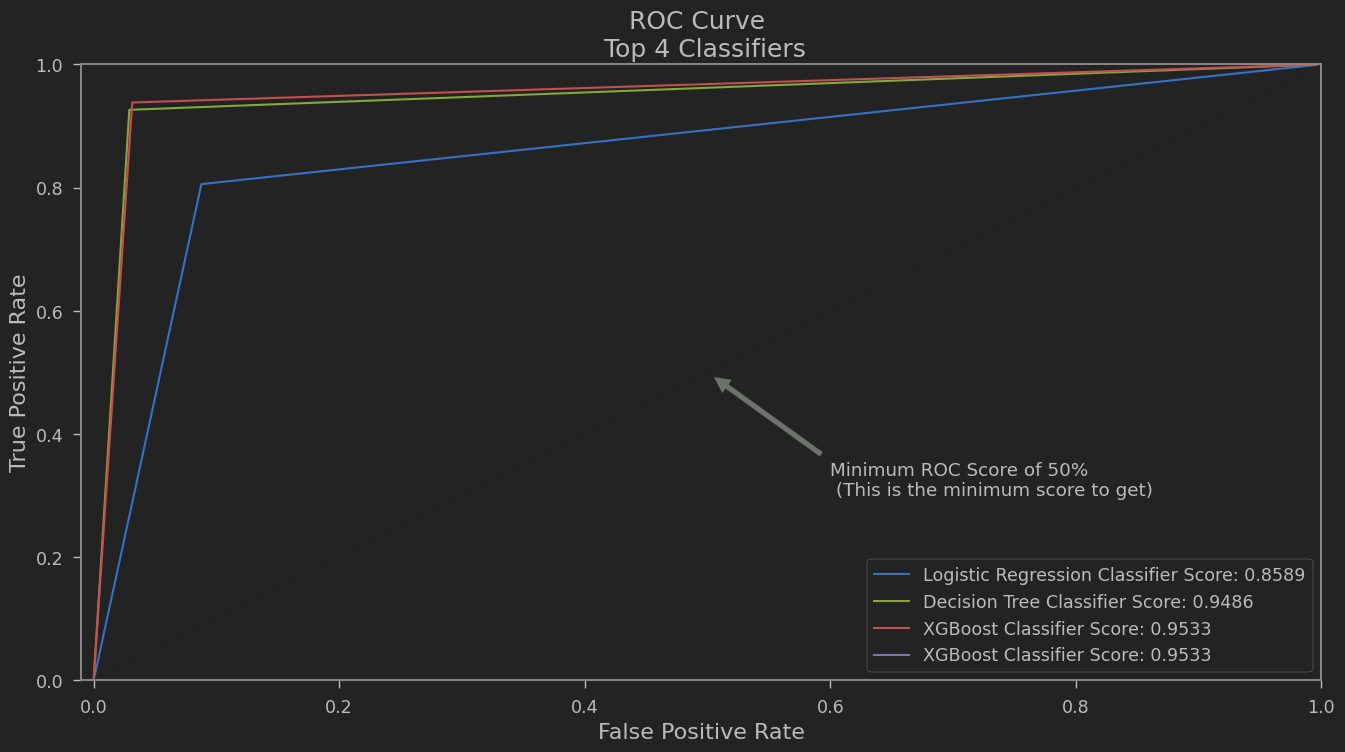

In [90]:
log_fpr, log_tpr, log_thresold = roc_curve(over_y_test, over_y_LR)
tree_fpr, tree_tpr, tree_threshold = roc_curve(over_y_test, over_y_RF)
XGB_fpr, XGB_tpr , XGB_threshold = roc_curve(over_y_test, over_y_XGB)


def graph_roc_curve_multiple(log_fpr, log_tpr, tree_fpr, tree_tpr,  XGB_fpr, XGB_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(aucLR))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(aurRF))
    plt.plot(XGB_fpr, XGB_tpr , XGB_threshold, label='XGBoost Classifier Score: {:.4f}'.format(aurcXGB))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, tree_fpr, tree_tpr, XGB_fpr, XGB_tpr)
plt.show()

### Score Table

In [91]:
metric


""
Logistic Regression Undersampled
Logistic Regression OverSampling
Random Forest Classifier Undersampling
Random Forest Classifier TOversampling
XGBoost Classifier Undersampling
XGBoost Classifier Oversampling
Logistic Regression Tuned
Random Forest Tuned
XGBoost Classifier Tuned


## Conclusion

In this project we analyzed several factors to understand the underlying pattern which can be used to detect fraudulent transactions. During the EDA process, we found out tha the dataset is highly imbalanced and in order to do meaningful modeling we will have to balance it. 2 methods were used – 1. Undersampling , 2. Oversampling (SMOTE) of data. Since this is a classification problem, we implemented three classification algorithms – 1. Logistic Regression, 2. Random Forest Classifier, 3. XGBoost Classifier. By visualizing and comparing each model’s score we can say that XGBoost classifiers gave the best performance with Recall score of around 97% for each class. 